In [8]:
%load_ext autoreload
%autoreload 2

from functools import reduce
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pymongo import MongoClient
from smartenergy.database import MinuteMeasurements, HourlyMeasurements
from smartenergy.ml_service.features import BatteryStateFeatures, BasicPreprocessor, DateFeatures, DataGrouper, Pipeline

from IPython.core.display import display, HTML
from jupyterthemes import jtplot
jtplot.style('onedork')

np.warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
display(HTML("<style>.container { width: 1600px !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
minute_measurements = MinuteMeasurements()
stations = minute_measurements.station_ids[:2]
data = {
    'MinuteMeasurements': minute_measurements.load_multiple_stations(stations, 1000),
}
print(data['MinuteMeasurements'].shape)
data['MinuteMeasurements'].sample(5)

(2000, 67)


EE/(SG+Bat) EE/SG E_Excess E_Excess_1        E_Load  E_LoadDirect  \
770         24%  414%        0        NaN  -55,98338333   0,399016667   
585          0%    0%        0        NaN       40,6555        -6,528   
680          0%    0%        0        NaN   40,85293333  -6,629046667   
855          0%    0%        0        NaN   45,60266667  -6,533333333   
853          0%    0%        0        NaN      44,31629  -6,527526667   

    E_LoadDirect_1 E_Load_1         E_PV E_PV_1     ...     u32Grid_mode  \
770            NaN      NaN      2,61625    NaN     ...              nan   
585            NaN      NaN  6,808386667    NaN     ...              nan   
680            NaN      NaN  6,843666667    NaN     ...              nan   
855            NaN      NaN    150,47503    NaN     ...              nan   
853            NaN      NaN  123,2103667    NaN     ...              nan   

    u32Load_mode u32OperationMode u32PV_mode u32TimeDelta_device  \
770          nan              171        nan                 nan   
585          nan              151        nan                 nan   
680          nan              151        nan                 nan   
855          nan              151        nan                 nan   
853          nan              151        nan                 nan   

          u32TimeStamp  u32TotalBought  u32TotalSold  u8StateOfBattery  \
770  31/10/17 01:59:02            4102           124                 3   
585  30/10/17 19:48:15           23180            20                 2   
680  30/10/17 23:01:03           23180            20                 2   
855  31/10/17 04:56:14           23180            20                 3   
853  31/10/17 04:52:07           23180            20                 3   

     u8UserMode  
770           0  
585           0  
680           0  
855           0  
853           0  

[5 rows x 67 columns]

In [10]:
migration_pipeline = Pipeline(
    preprocessors=[
        BasicPreprocessor(),
        DateFeatures(),
    ],
    features=[
        DataGrouper(),
        BatteryStateFeatures(),
    ]
)
data = migration_pipeline.transform(data)
data_hourly = data['DataGrouper']
data_hourly = pd.merge(data['DataGrouper'], data['BatteryStateFeatures'], on=['solbox_id', 'datetime'], how='outer')
print(data_hourly.shape)
data_hourly.head()

INFO:2018-09-16 16:12:00,106:root:::Running preprocessor BasicPreprocessor
INFO:2018-09-16 16:12:01,547:root:::Running preprocessor DateFeatures
INFO:2018-09-16 16:12:01,577:root:::Running feature DataGrouper
INFO:2018-09-16 16:12:01,719:root:::Running feature BatteryStateFeatures
(68, 18)


year  month  day  hour  energy_generation_i  \
solbox_id datetime                                                           
48        2017-10-30 06:00:00  2017     10   30     6               152.21   
          2017-10-30 07:00:00  2017     10   30     7               168.89   
          2017-10-30 08:00:00  2017     10   30     8               194.50   
          2017-10-30 09:00:00  2017     10   30     9               168.86   
          2017-10-30 10:00:00  2017     10   30    10               171.24   

                               energy_consumption_i  energy_excess_i  \
solbox_id datetime                                                     
48        2017-10-30 06:00:00                 42.68             0.00   
          2017-10-30 07:00:00                 57.17             0.00   
          2017-10-30 08:00:00                 70.54             0.00   
          2017-10-30 09:00:00                 52.11             0.00   
          2017-10-30 10:00:00                 41.35             0.00   

                               energy_to_grid_i  energy_to_battery_i  \
solbox_id datetime                                                     
48        2017-10-30 06:00:00            743.97              -327.75   
          2017-10-30 07:00:00            763.04              1362.60   
          2017-10-30 08:00:00            758.63              2974.16   
          2017-10-30 09:00:00            742.11              1403.80   
          2017-10-30 10:00:00            748.90              1391.29   

                               temperature  battery_state_discrete  \
solbox_id datetime                                                   
48        2017-10-30 06:00:00       777.06                       3   
          2017-10-30 07:00:00       775.47                       3   
          2017-10-30 08:00:00       786.45                       3   
          2017-10-30 09:00:00       810.27                       3   
          2017-10-30 10:00:00       835.04                       3   

                               battery_state_continuous_at_change  \
solbox_id datetime                                                  
48        2017-10-30 06:00:00                                 nan   
          2017-10-30 07:00:00                                 nan   
          2017-10-30 08:00:00                                 nan   
          2017-10-30 09:00:00                                 nan   
          2017-10-30 10:00:00                                 nan   

                               battery_state_continuous_theoretical  \
solbox_id datetime                                                    
48        2017-10-30 06:00:00                                   nan   
          2017-10-30 07:00:00                                   nan   
          2017-10-30 08:00:00                                   nan   
          2017-10-30 09:00:00                                   nan   
          2017-10-30 10:00:00                                   nan   

                               battery_state_continuous_computed  \
solbox_id datetime                                                 
48        2017-10-30 06:00:00                                nan   
          2017-10-30 07:00:00                                nan   
          2017-10-30 08:00:00                                nan   
          2017-10-30 09:00:00                                nan   
          2017-10-30 10:00:00                                nan   

                               energy_to_battery_untracked_i  \
solbox_id datetime                                             
48        2017-10-30 06:00:00                           0.00   
          2017-10-30 07:00:00                           0.00   
          2017-10-30 08:00:00                           0.00   
          2017-10-30 09:00:00                           0.00   
          2017-10-30 10:00:00                           0.00   

                               energy_generation_computed_i  \
solbox_id da

In [6]:
hourly_measurements = HourlyMeasurements()
hourly_measurements.drop()
hourly_measurements.insert_many(data_hourly.reset_index().to_dict('records'))


(58586, 11)


year  month   day  hour  energy_generation_i  \
solbox_id datetime                                                              
190       2018-01-28 11:00:00 2018.00   1.00 28.00 11.00                53.29   
          2018-01-28 12:00:00     nan    nan   nan   nan                  nan   
          2018-01-28 13:00:00     nan    nan   nan   nan                  nan   
          2018-01-28 14:00:00     nan    nan   nan   nan                  nan   
          2018-01-28 15:00:00     nan    nan   nan   nan                  nan   

                               energy_consumption_i  energy_excess_i  \
solbox_id datetime                                                     
190       2018-01-28 11:00:00                649.14             0.50   
          2018-01-28 12:00:00                   nan              nan   
          2018-01-28 13:00:00                   nan              nan   
          2018-01-28 14:00:00                   nan              nan   
          2018-01-28 15:00:00                   nan              nan   

                               energy_to_grid_i  energy_to_battery_i  \
solbox_id datetime                                                     
190       2018-01-28 11:00:00              0.00                 0.00   
          2018-01-28 12:00:00               nan                  nan   
          2018-01-28 13:00:00               nan                  nan   
          2018-01-28 14:00:00               nan                  nan   
          2018-01-28 15:00:00               nan                  nan   

                               temperature  battery_state_discrete  
solbox_id datetime                                                  
190       2018-01-28 11:00:00       712.50                    2.00  
          2018-01-28 12:00:00          nan                     nan  
          2018-01-28 13:00:00          nan                     nan  
          2018-01-28 14:00:00          nan                     nan  
          2018-01-28 15:00:00          nan                     nan

### Analyzing untracked energy going to the battery

KeyError: 'energy_to_battery_i'

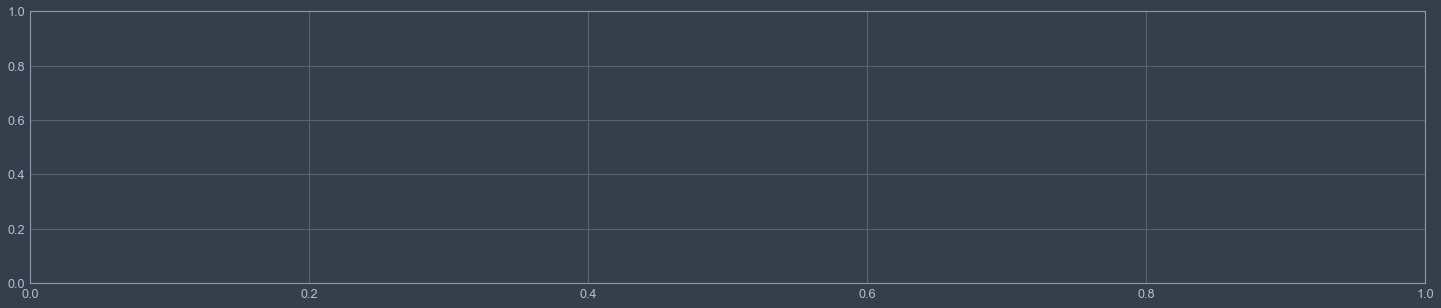

In [35]:
import random
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

station = random.choice(range(3))
for var in ['energy_to_battery_i', 'energy_to_battery_untracked_i', 'battery_state_continuous_theoretical', 'battery_state_continuous_computed']:
    fig, ax = plt.subplots(1, 1, figsize=(25, 5))
    plt.plot(data.loc[data.reset_index()['solbox_id'].unique()[station]].reset_index().set_index('datetime')[var])
    if var in ['battery_state_continuous_theoretical', 'battery_state_continuous_computed']:
        _data = data.loc[data.reset_index()['solbox_id'].unique()[station]].reset_index()
        plt.scatter(_data['datetime'].values, _data['battery_state_continuous_at_change'].values)
    plt.title(var)
    ax.set_facecolor('#292929')
    plt.show()

In [32]:
data['energy_to_battery_untracked_i'].abs().groupby('solbox_id').sum() / data['energy_to_battery_i'].abs().groupby('solbox_id').sum()

solbox_id
48   0.72
68   0.94
71   0.86
dtype: float64

### Analyze missingness patterns

In [10]:
hourly_measurements = HourlyMeasurements()
data = hourly_measurements.load().set_index(['solbox_id', 'datetime'])
stations = hourly_measurements.station_ids
print(data.shape)
data.head()

(44462, 11)


battery_state_discrete  day  \
solbox_id datetime                                           
190       2018-01-28 11:00:00                       2   28   
          2018-02-02 12:00:00                       3    2   
          2018-02-02 16:00:00                       3    2   
          2018-02-02 17:00:00                       3    2   
          2018-02-02 18:00:00                       3    2   

                               energy_consumption_i  energy_excess_i  \
solbox_id datetime                                                     
190       2018-01-28 11:00:00                649.14             0.50   
          2018-02-02 12:00:00                 20.44             0.00   
          2018-02-02 16:00:00                234.17             1.04   
          2018-02-02 17:00:00               4606.05             0.00   
          2018-02-02 18:00:00              13608.08             0.00   

                               energy_generation_i  energy_to_battery_i  \
solbox_id datetime                                                        
190       2018-01-28 11:00:00                53.29                 0.00   
          2018-02-02 12:00:00               425.37               281.39   
          2018-02-02 16:00:00              1118.50              -501.79   
          2018-02-02 17:00:00              1412.26             -4866.38   
          2018-02-02 18:00:00              1916.84            -13409.76   

                               energy_to_grid_i  hour  month  temperature  \
solbox_id datetime                                                          
190       2018-01-28 11:00:00              0.00    11      1       712.50   
          2018-02-02 12:00:00            -12.56    12      2       668.40   
          2018-02-02 16:00:00           -155.69    16      2       727.69   
          2018-02-02 17:00:00          -1266.84    17      2       716.21   
          2018-02-02 18:00:00          -2820.09    18      2       701.91   

                               year  
solbox_id datetime                   
190       2018-01-28 11:00:00  2018  
          2018-02-02 12:00:00  2018  
          2018-02-02 16:00:00  2018  
          2018-02-02 17:00:00  2018  
          2018-02-02 18:00:00  2018

In [11]:


dates_list = list()
for _id in stations:
    min_date, max_date = min(data.loc[_id].reset_index()['datetime']), max(data.loc[_id].reset_index()['datetime'])
    _dates = pd.date_range(min_date, max_date, freq='H')
    dates = pd.DataFrame({
        'datetime': _dates,
        'solbox_id': [_id] * len(_dates),
    })
    dates_list.append(dates)

dates = pd.concat(dates_list).set_index(['solbox_id', 'datetime'])
print(dates.head())
print(dates.shape)
data = data.join(dates, how='outer')

Empty DataFrame
Columns: []
Index: [(190, 2018-01-28 11:00:00), (190, 2018-01-28 12:00:00), (190, 2018-01-28 13:00:00), (190, 2018-01-28 14:00:00), (190, 2018-01-28 15:00:00)]
(58586, 0)


In [12]:
data.isnull().groupby('solbox_id').mean()['hour']

solbox_id
190   0.46
30    0.11
309   0.53
32    0.09
34    0.07
344   0.68
345   0.40
366   0.40
369   0.47
37    0.06
40    0.06
43    0.14
47    0.14
48    0.20
68    0.21
71    0.32
97    0.47
Name: hour, dtype: float64

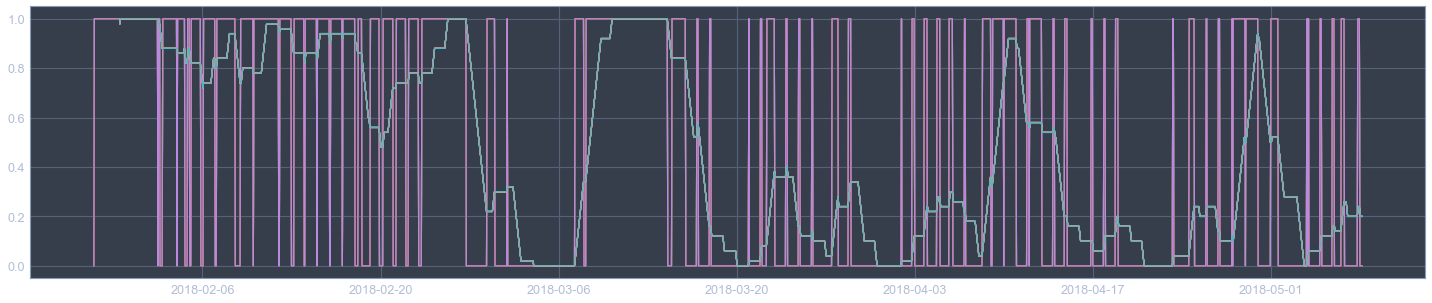

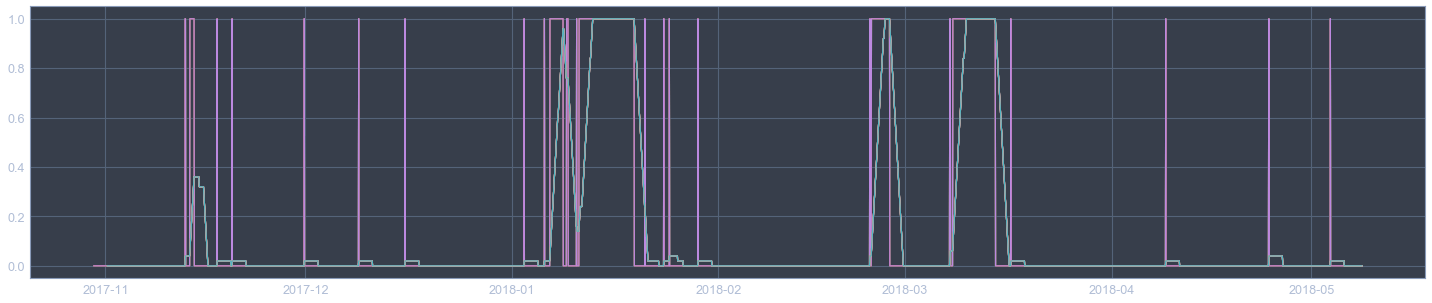

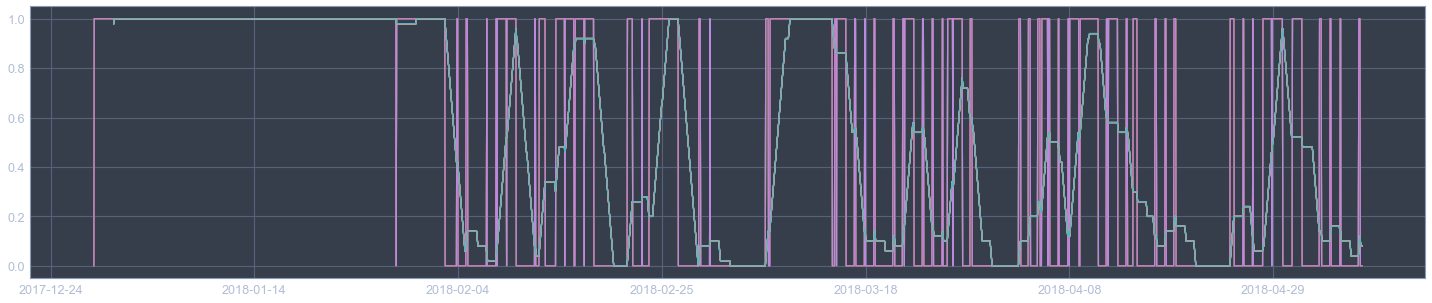

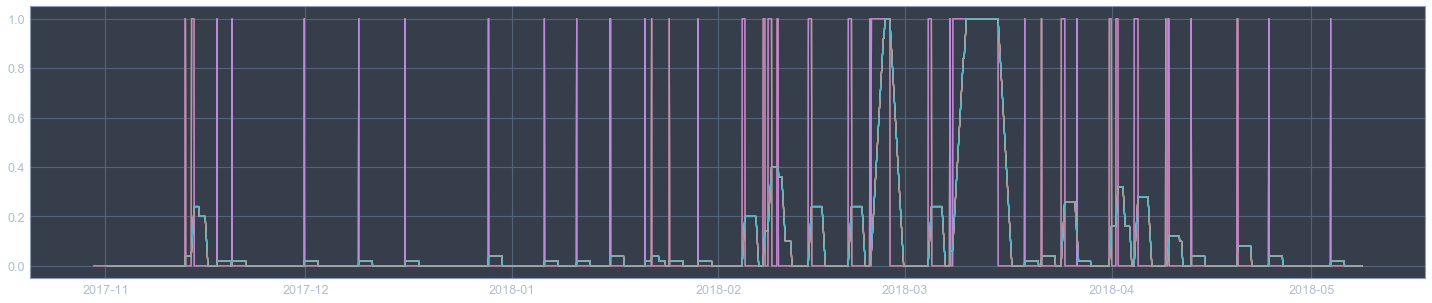

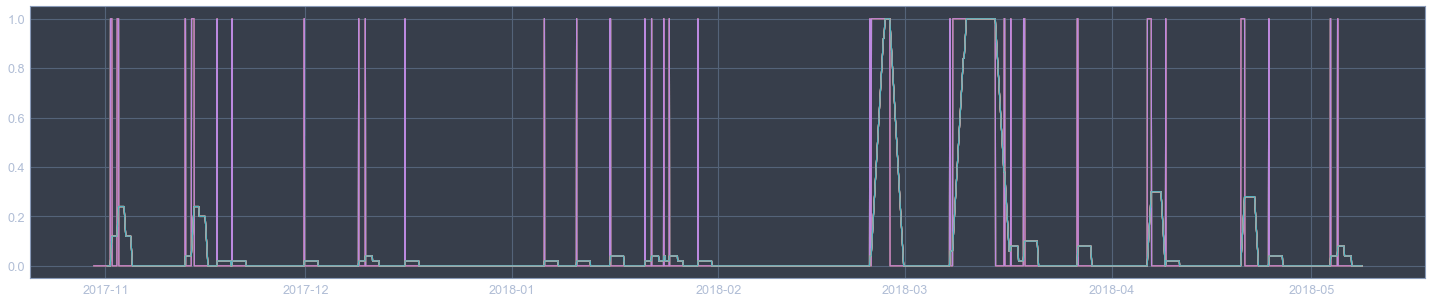

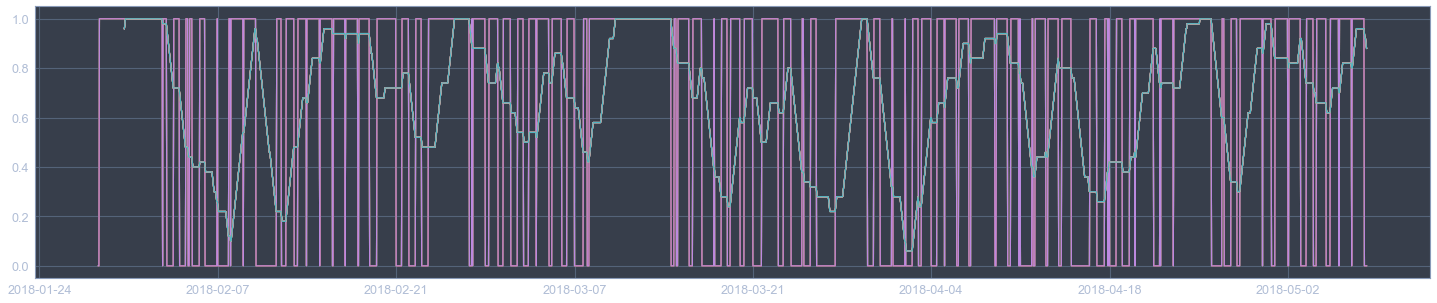

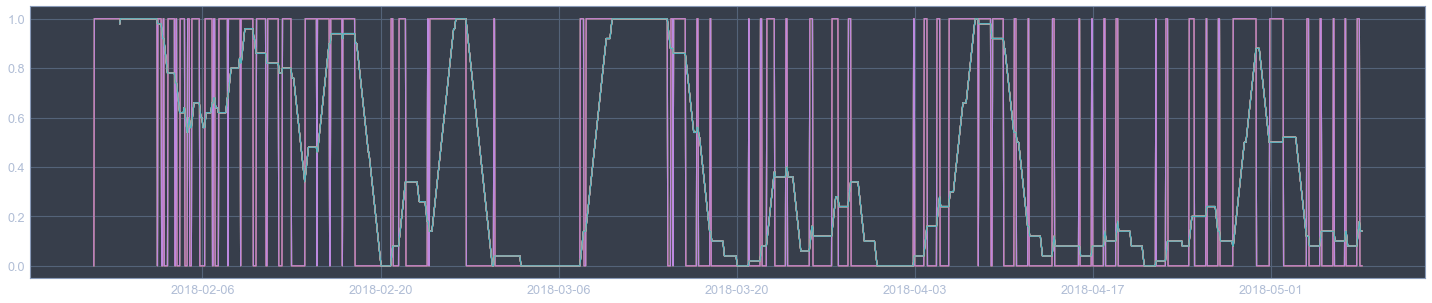

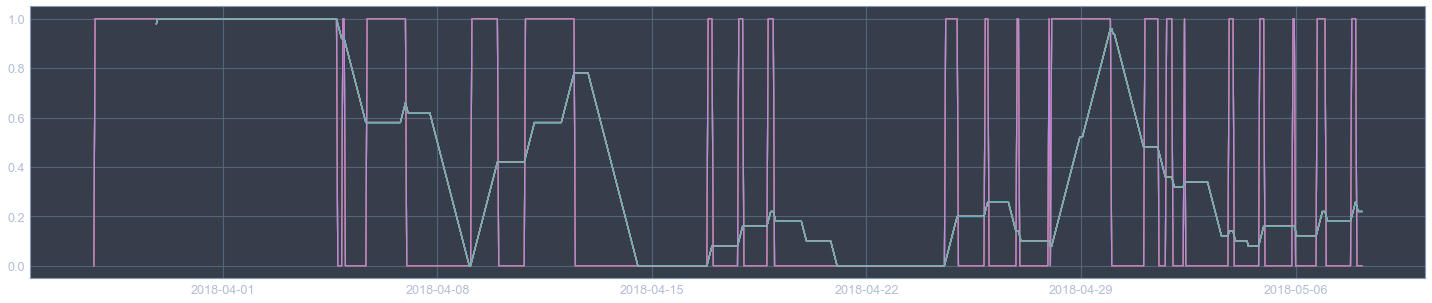

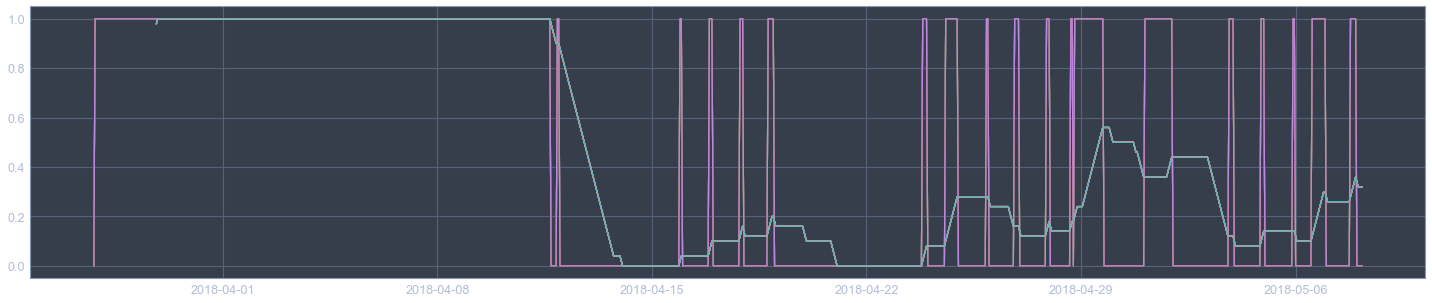

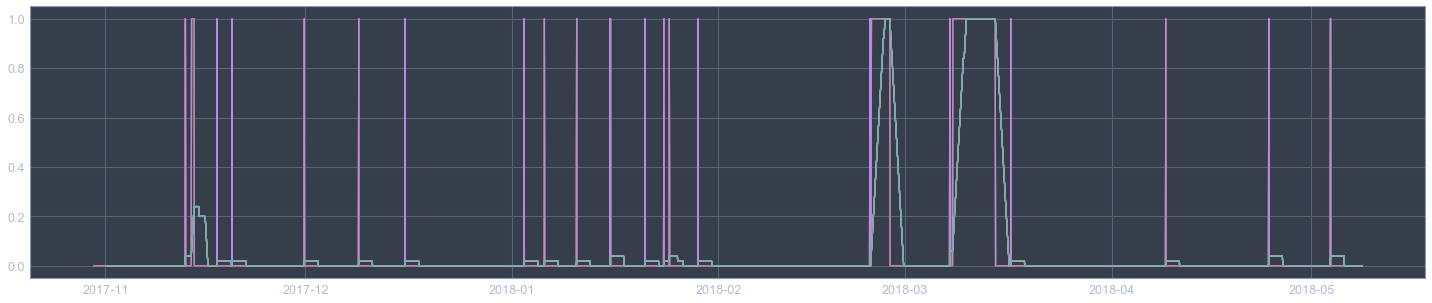

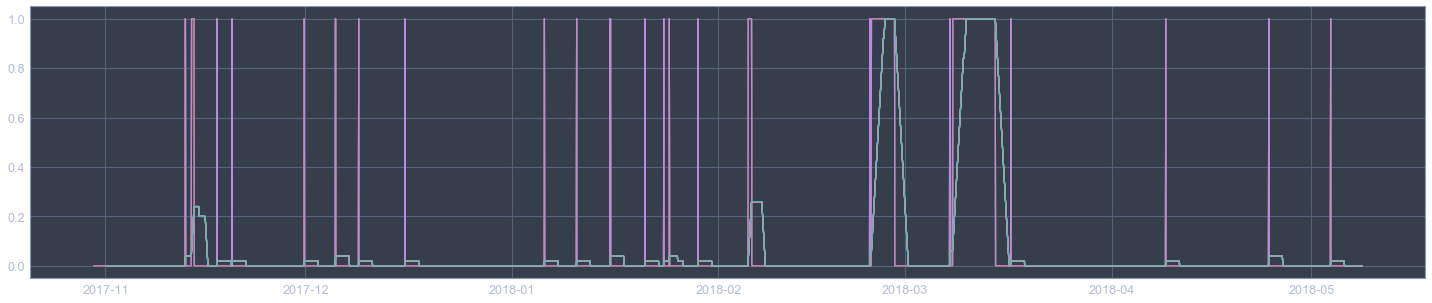

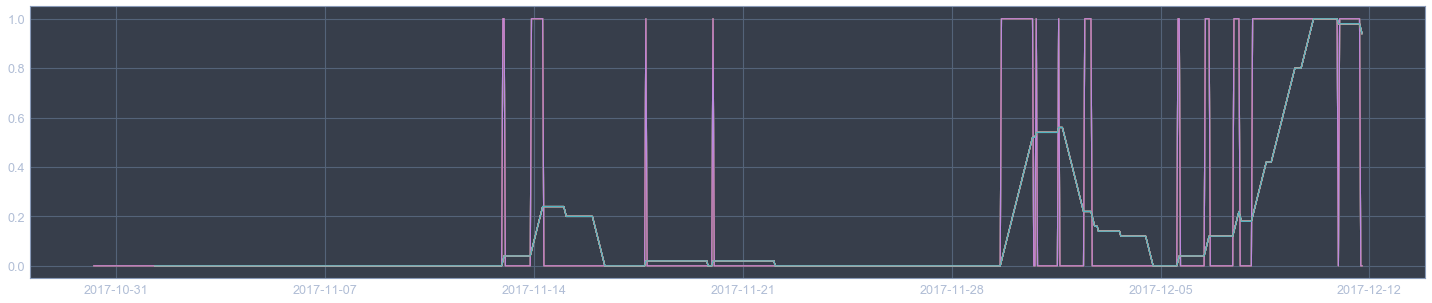

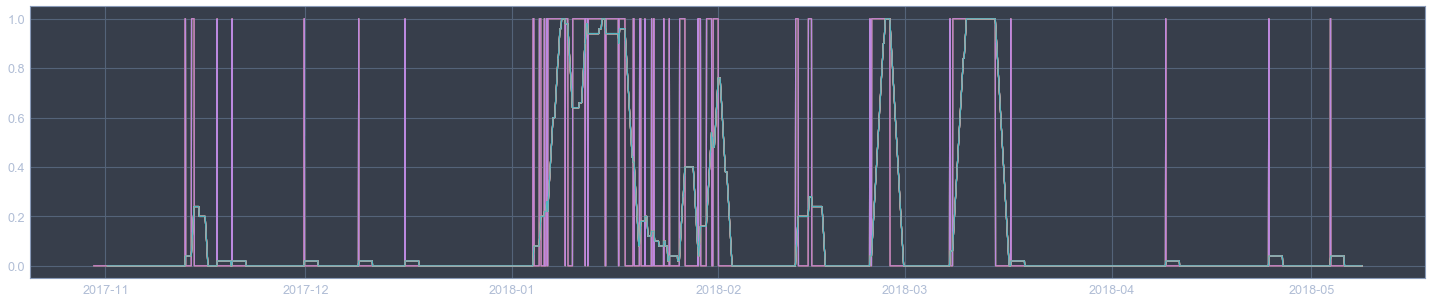

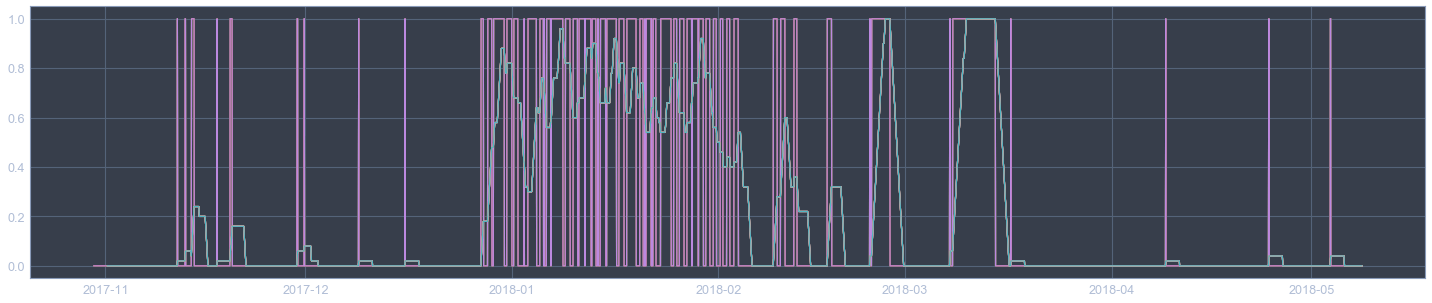

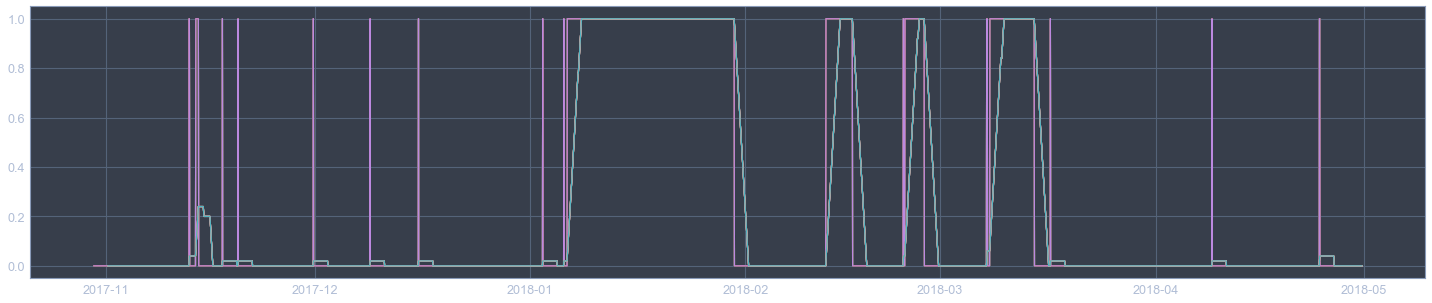

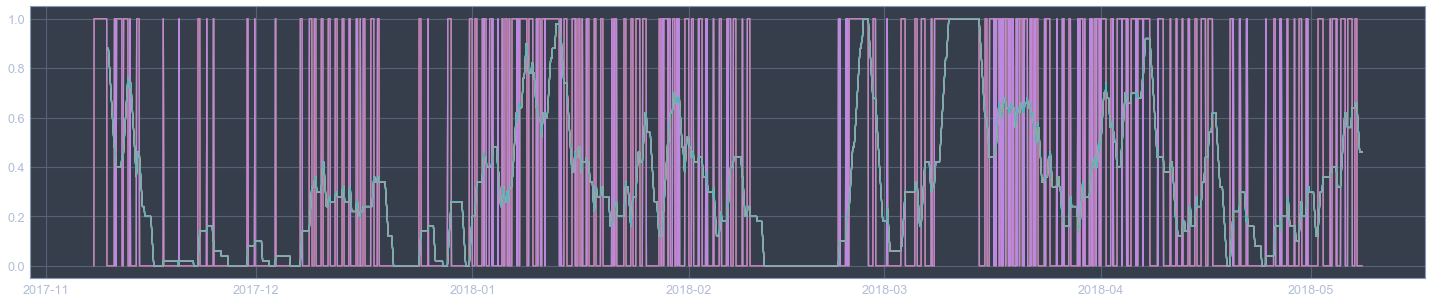

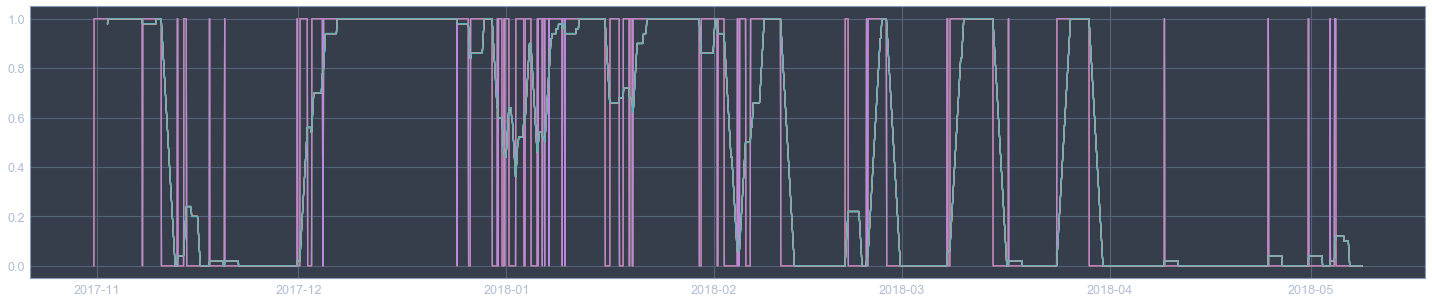

In [18]:
for station in stations:
    plt.figure(figsize=(25, 5))
    plt.plot(data.loc[station].isnull())
    plt.plot(data.loc[station].isnull().rolling(50).mean())
    plt.show()

In [74]:
from xgboost import XGBRegressor

def impute_missing_one_station(data):
    lags = 24
    model = XGBRegressor()
    for i in range(1, lags+1):
        data[f'energy_generation_i_lag_{i}'] = data[f'energy_generation_i'].shift(i)

    features = [f'energy_generation_i_lag_{i}' for i in range(1, lags+1)]
    model.fit(data.dropna(subset=['energy_generation_i'])[features], data['energy_generation_i'].dropna())
    predictions = pd.DataFrame({
        'predictions': model.predict(data.loc[data['energy_generation_i'].isnull(), features])
    }, index=data.loc[data['energy_generation_i'].isnull()].index)
    return predictions

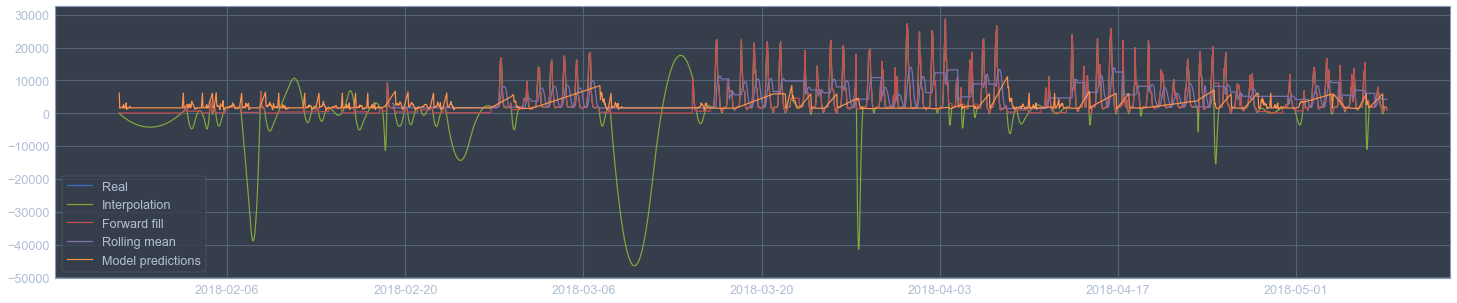

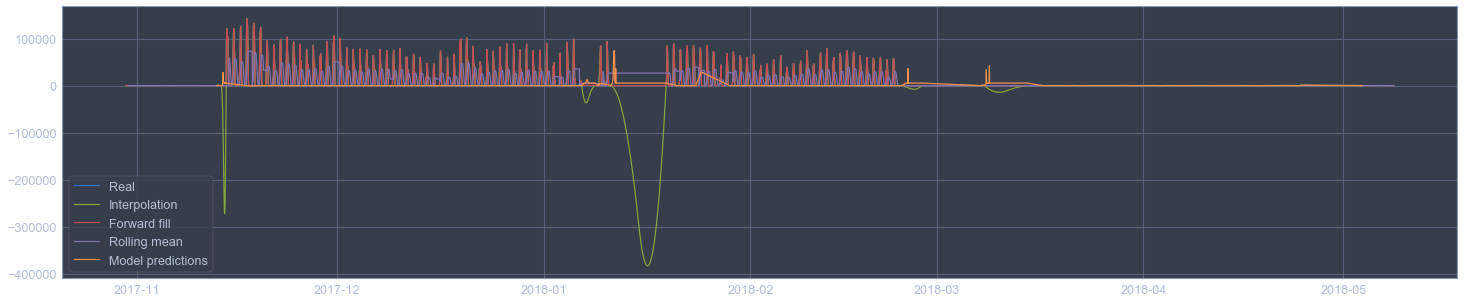

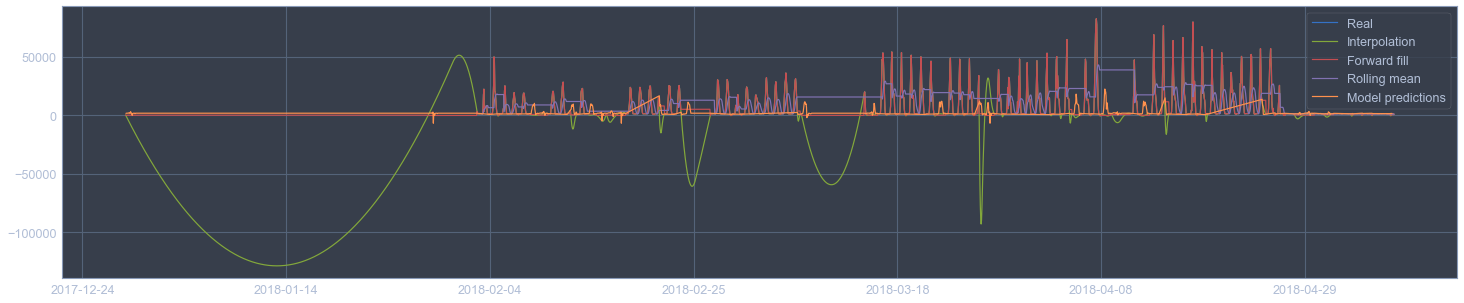

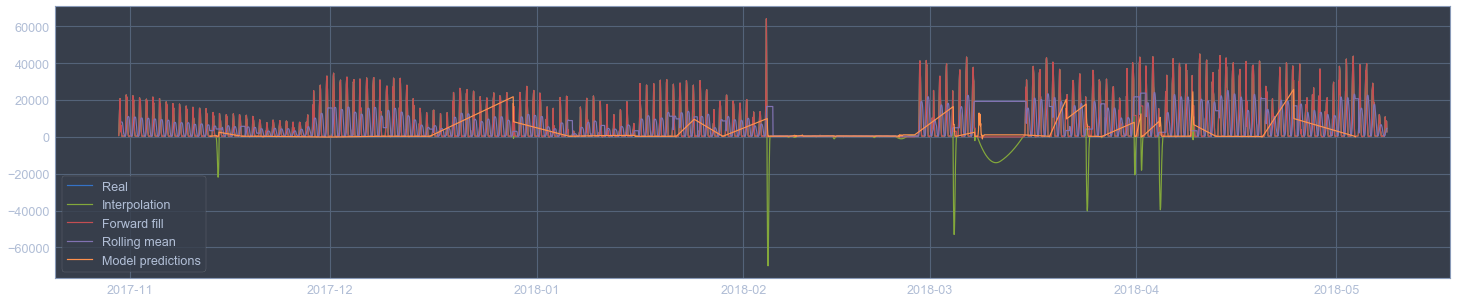

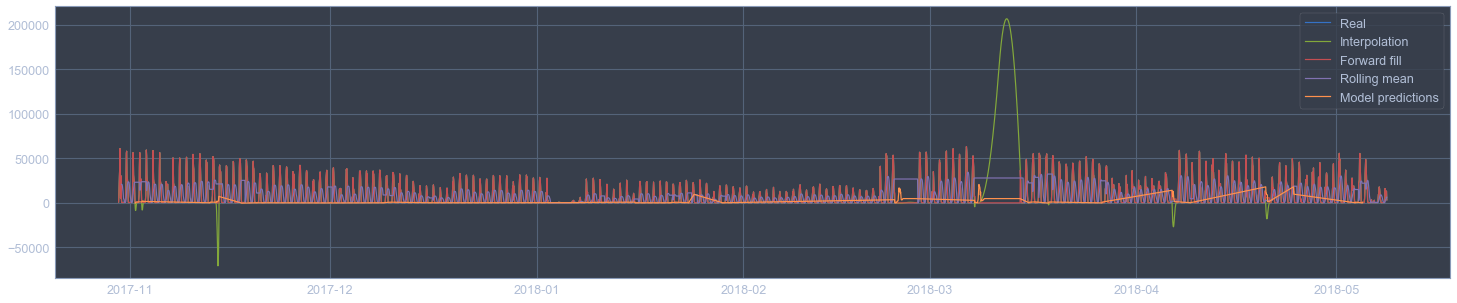

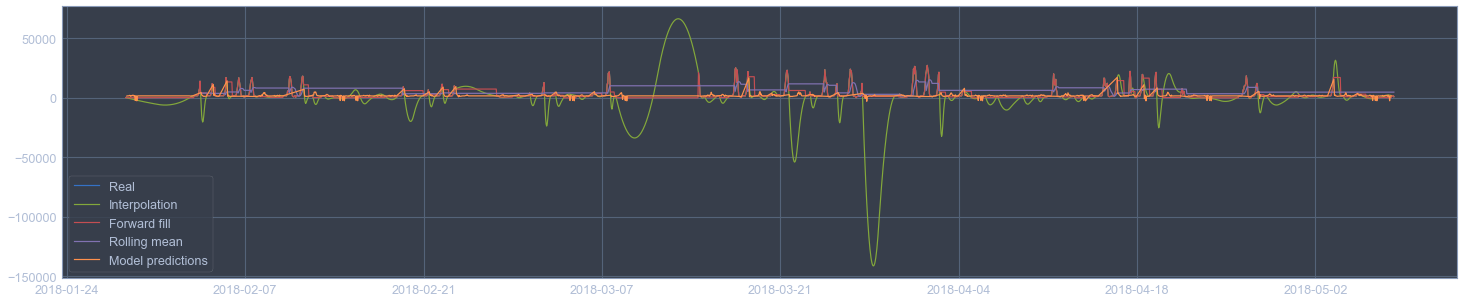

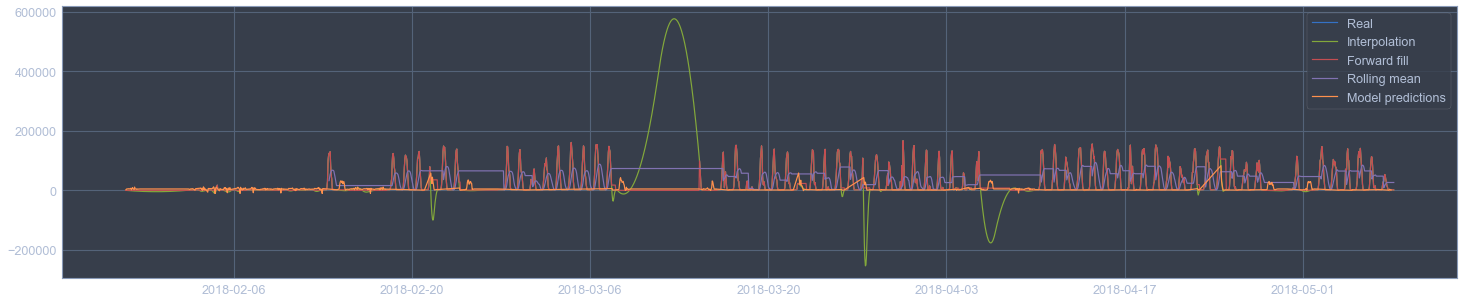

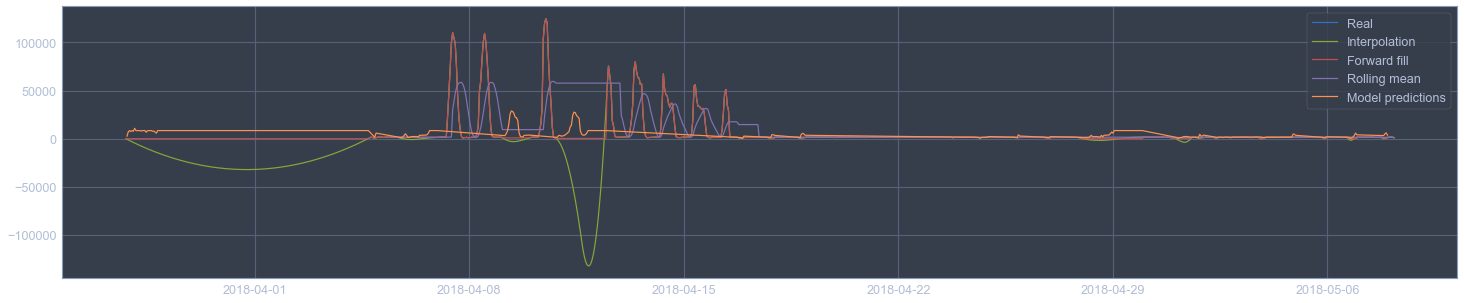

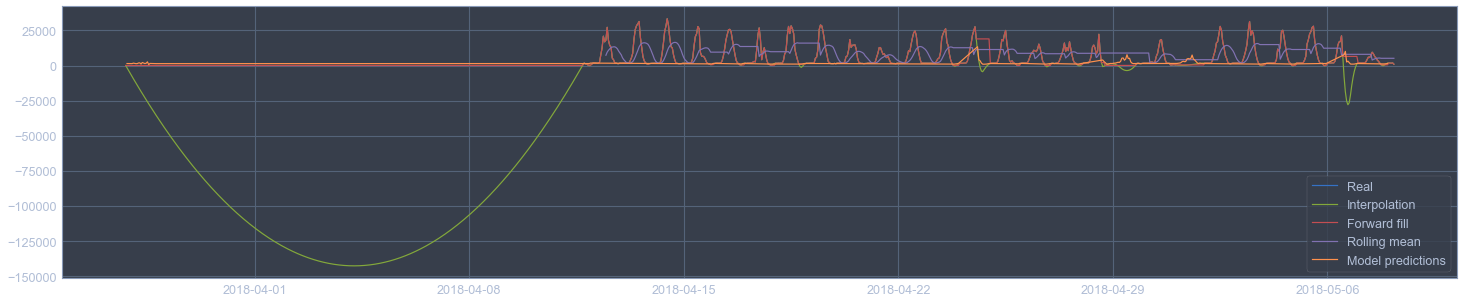

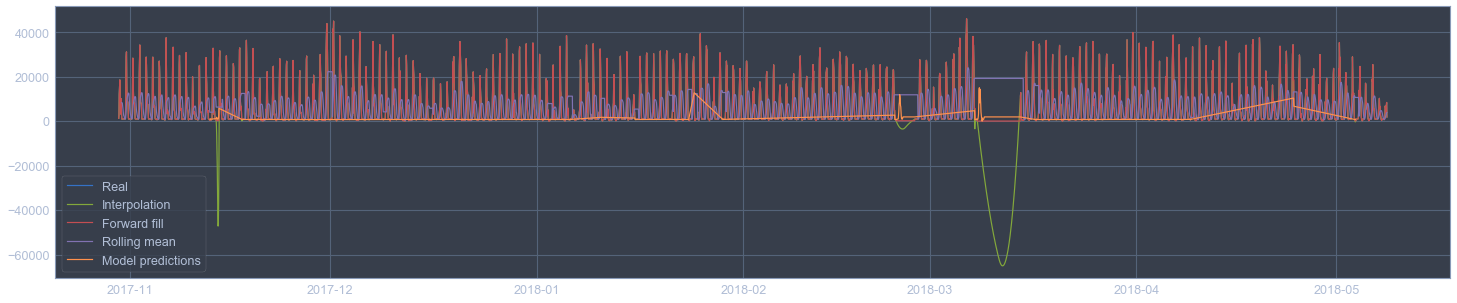

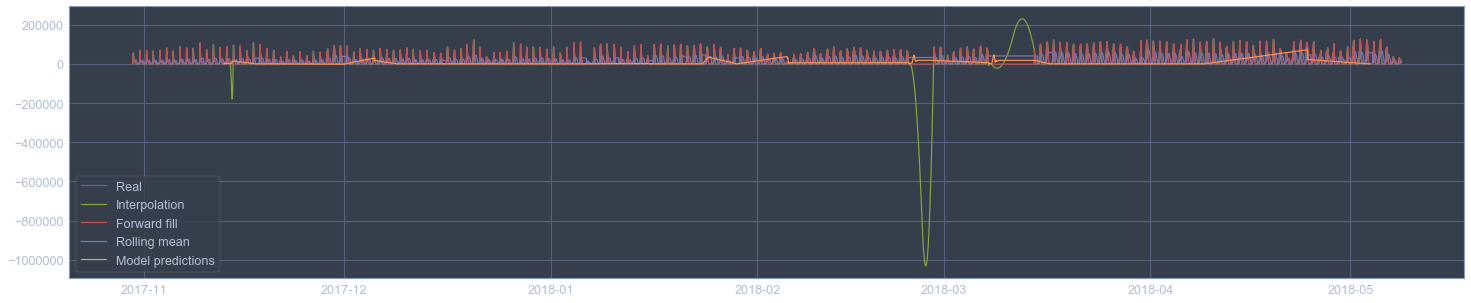

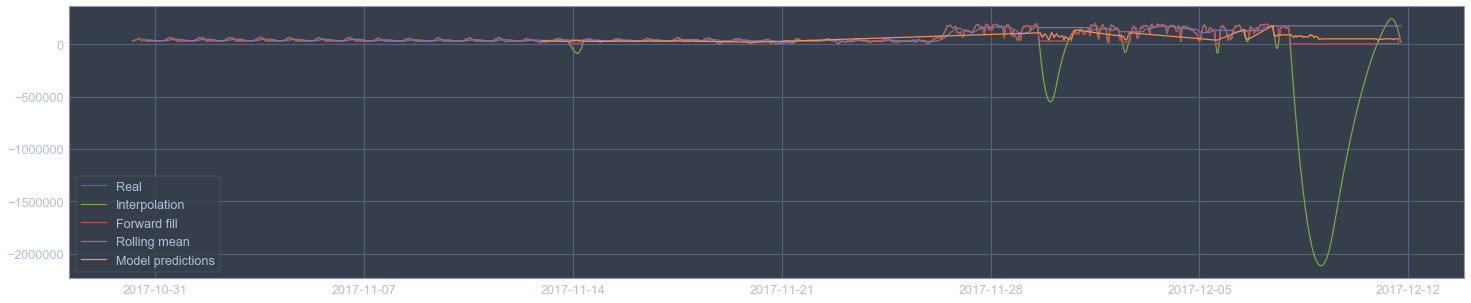

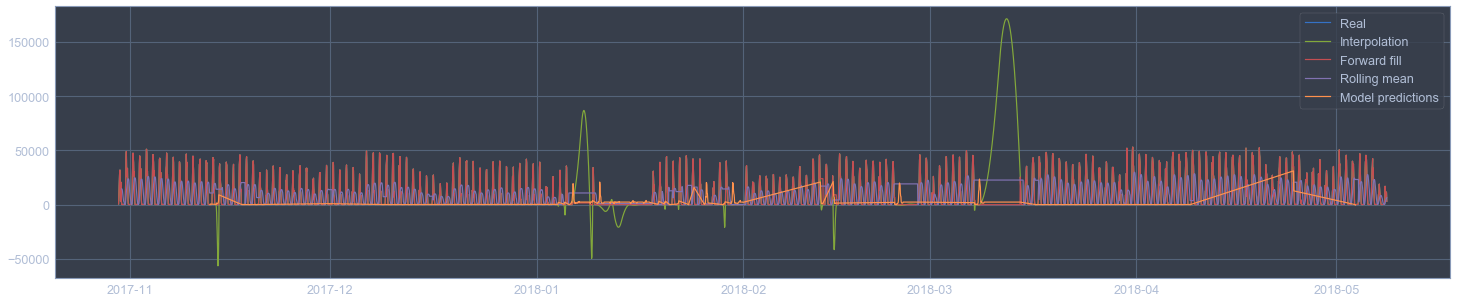

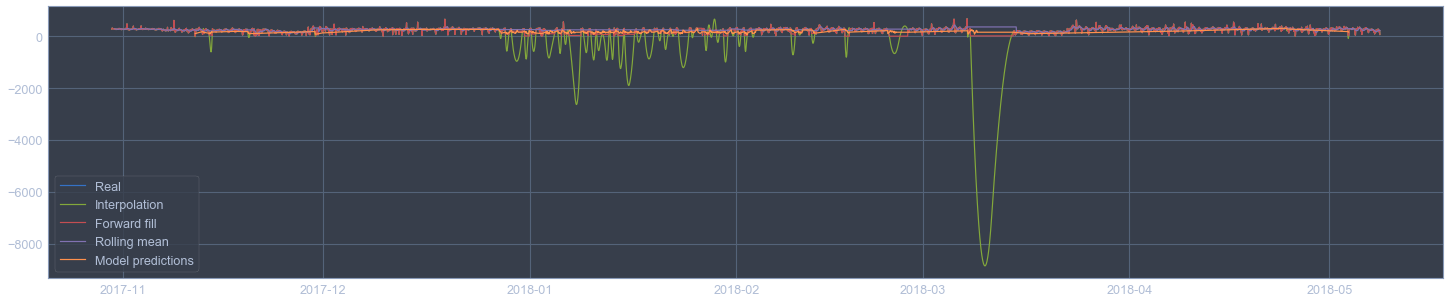

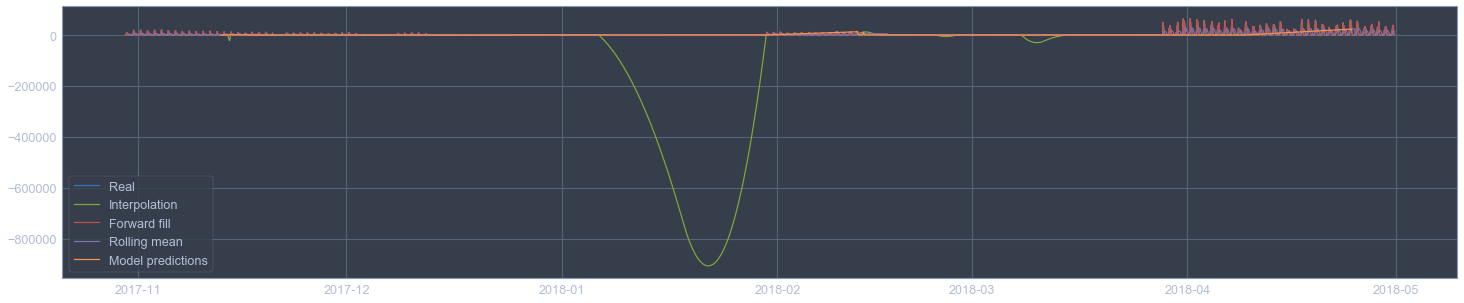

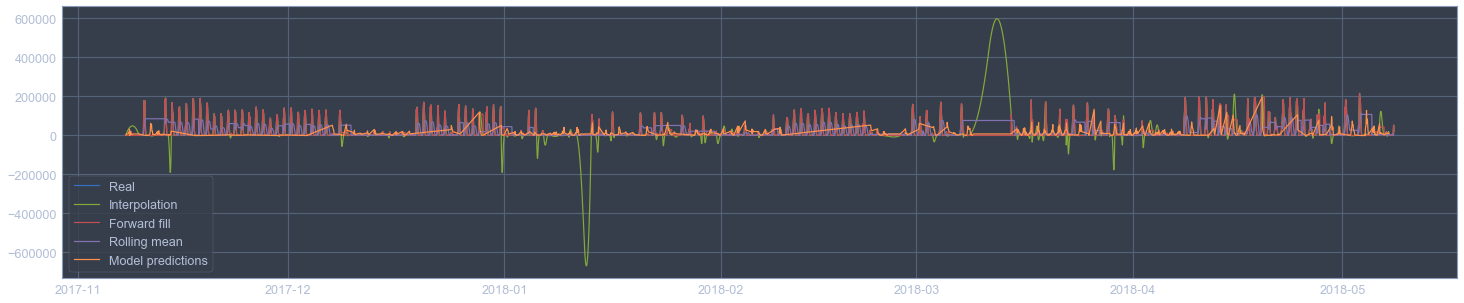

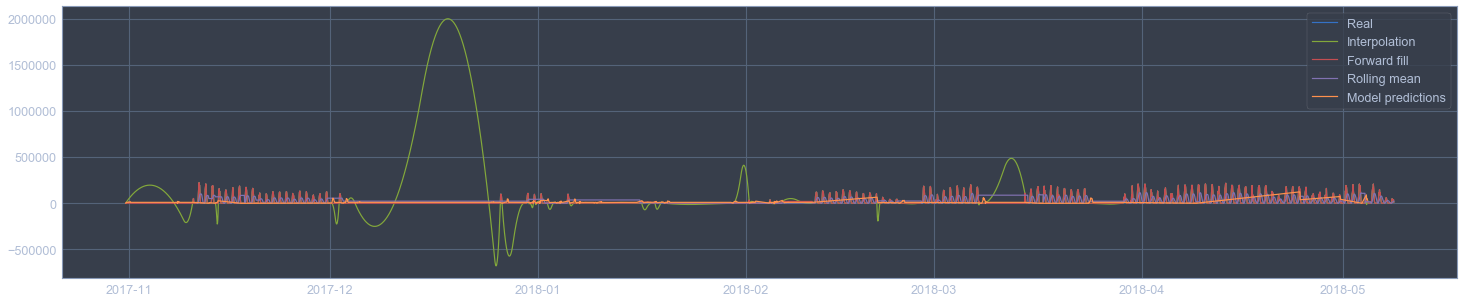

In [77]:
for station in stations:
    plt.figure(figsize=(25, 5))
    plt.plot(data.loc[station, 'energy_generation_i'], label='Real')
    plt.plot(data.loc[station, 'energy_generation_i'].interpolate(method='spline', order=2), label='Interpolation')
    plt.plot(data.loc[station, 'energy_generation_i'].ffill(), label='Forward fill')
    plt.plot(data.loc[station, 'energy_generation_i'].rolling(12).mean().ffill(), label='Rolling mean')
    predictions = impute_missing_one_station(data.loc[station])
    plt.plot(predictions, label='Model predictions')
    plt.legend()
    plt.show()

In [196]:
loads = hourly_data['fILoadDirect_avg'].copy()
print(loads.isnull().sum())
loads.loc[loads.isnull()] = loads.rolling(24, 12).mean().loc[loads.isnull()]
loads.head()
print(loads.isnull().sum())

6785
6097


In [152]:
hourly_data.head()

day  fIExcess_avg  fILoadDirect_avg  \
solbox_id datetime                                                    
190       2018-01-28 11:00:00 28.00          0.79            763.10   
          2018-01-28 12:00:00   nan           nan               nan   
          2018-01-28 13:00:00   nan           nan               nan   
          2018-01-28 14:00:00   nan           nan               nan   
          2018-01-28 15:00:00   nan           nan               nan   

                               fILoad_avg  fIPV_avg  fIToBat_avg  \
solbox_id datetime                                                 
190       2018-01-28 11:00:00     2533.30   1142.58         0.00   
          2018-01-28 12:00:00         nan       nan          nan   
          2018-01-28 13:00:00         nan       nan          nan   
          2018-01-28 14:00:00         nan       nan          nan   
          2018-01-28 15:00:00         nan       nan          nan   

                               fIToGrid_avg  fTemperature_avg  hour  month  \
solbox_id datetime                                                           
190       2018-01-28 11:00:00          0.00             23.75 11.00   1.00   
          2018-01-28 12:00:00           nan               nan   nan    nan   
          2018-01-28 13:00:00           nan               nan   nan    nan   
          2018-01-28 14:00:00           nan               nan   nan    nan   
          2018-01-28 15:00:00           nan               nan   nan    nan   

                               u8StateOfBattery    year  
solbox_id datetime                                       
190       2018-01-28 11:00:00              2.00 2018.00  
          2018-01-28 12:00:00               nan     nan  
          2018-01-28 13:00:00               nan     nan  
          2018-01-28 14:00:00               nan     nan  
          2018-01-28 15:00:00               nan     nan

In [131]:
rolling_data.set_index(['solbox_id', 'datetime']).head()

level_1  fIExcess_avg  fILoadDirect_avg  \
solbox_id datetime                                                       
190       2018-01-28 11:00:00        0           nan               nan   
          2018-01-28 12:00:00        1           nan               nan   
          2018-01-28 13:00:00        2           nan               nan   
          2018-01-28 14:00:00        3           nan               nan   
          2018-01-28 15:00:00        4           nan               nan   

                               fILoad_avg  fIPV_avg  fIToBat_avg  \
solbox_id datetime                                                 
190       2018-01-28 11:00:00         nan       nan          nan   
          2018-01-28 12:00:00         nan       nan          nan   
          2018-01-28 13:00:00         nan       nan          nan   
          2018-01-28 14:00:00         nan       nan          nan   
          2018-01-28 15:00:00         nan       nan          nan   

                               fIToGrid_avg  fTemperature_avg  \
solbox_id datetime                                              
190       2018-01-28 11:00:00           nan               nan   
          2018-01-28 12:00:00           nan               nan   
          2018-01-28 13:00:00           nan               nan   
          2018-01-28 14:00:00           nan               nan   
          2018-01-28 15:00:00           nan               nan   

                               u8StateOfBattery  
solbox_id datetime                               
190       2018-01-28 11:00:00               nan  
          2018-01-28 12:00:00               nan  
          2018-01-28 13:00:00               nan  
          2018-01-28 14:00:00               nan  
          2018-01-28 15:00:00               nan

In [197]:
hourly_data.columns

Index(['day', 'fIExcess_avg', 'fILoadDirect_avg', 'fILoad_avg', 'fIPV_avg',
       'fIToBat_avg', 'fIToGrid_avg', 'fTemperature_avg', 'hour', 'month',
       'u8StateOfBattery', 'year'],
      dtype='object')

In [ ]:
features_to_fill = ['fIExcess_avg', 'fILoadDirect_avg', 'fILoad_avg', 'fIPV_avg',
                    'fIToBat_avg', 'fIToGrid_avg', 'fTemperature_avg']

In [170]:
for var in features_to_fill:
    _var = hourly_data[var]
    hourly_data = hourly_data[var].reset_index().drop(['datetime', 'year', 'hour', 'month', 'day'], axis=1).copy()
    rolling_data = full_data\
        .groupby('solbox_id').rolling(24, min_periods=1).mean()\
        .drop('solbox_id', axis=1).reset_index()
    rolling_data['datetime'] = hourly_data.reset_index()['datetime']
    full_data[full_data.isnull()] = rolling_data.set_index(['solbox_id', 'datetime'])[full_data.isnull()]

ValueError: cannot join with no level specified and no overlapping names

In [171]:
rolling_data.head()

solbox_id  level_1  fIExcess_avg  fILoadDirect_avg  fILoad_avg  fIPV_avg  \
0       190        0          0.79            763.10     2533.30   1142.58   
1       190        1          0.79            763.10     2533.30   1142.58   
2       190        2          0.79            763.10     2533.30   1142.58   
3       190        3          0.79            763.10     2533.30   1142.58   
4       190        4          0.79            763.10     2533.30   1142.58   

   fIToBat_avg  fIToGrid_avg  fTemperature_avg  u8StateOfBattery  \
0         0.00          0.00             23.75              2.00   
1         0.00          0.00             23.75              2.00   
2         0.00          0.00             23.75              2.00   
3         0.00          0.00             23.75              2.00   
4         0.00          0.00             23.75              2.00   

             datetime  
0 2018-01-28 11:00:00  
1 2018-01-28 12:00:00  
2 2018-01-28 13:00:00  
3 2018-01-28 14:00:00  
4 2018-01-28 15:00:00

In [169]:
full_data.head()

day  fIExcess_avg  fILoadDirect_avg  \
solbox_id datetime                                                    
190       2018-01-28 11:00:00 28.00          0.79            763.10   
          2018-01-28 12:00:00   nan          0.79            763.10   
          2018-01-28 13:00:00   nan          0.79            763.10   
          2018-01-28 14:00:00   nan          0.79            763.10   
          2018-01-28 15:00:00   nan          0.79            763.10   

                               fILoad_avg  fIPV_avg  fIToBat_avg  \
solbox_id datetime                                                 
190       2018-01-28 11:00:00     2533.30   1142.58         0.00   
          2018-01-28 12:00:00     2533.30   1142.58         0.00   
          2018-01-28 13:00:00     2533.30   1142.58         0.00   
          2018-01-28 14:00:00     2533.30   1142.58         0.00   
          2018-01-28 15:00:00     2533.30   1142.58         0.00   

                               fIToGrid_avg  fTemperature_avg  hour  month  \
solbox_id datetime                                                           
190       2018-01-28 11:00:00          0.00             23.75 11.00   1.00   
          2018-01-28 12:00:00          0.00             23.75   nan    nan   
          2018-01-28 13:00:00          0.00             23.75   nan    nan   
          2018-01-28 14:00:00          0.00             23.75   nan    nan   
          2018-01-28 15:00:00          0.00             23.75   nan    nan   

                               u8StateOfBattery    year  
solbox_id datetime                                       
190       2018-01-28 11:00:00              2.00 2018.00  
          2018-01-28 12:00:00              2.00     nan  
          2018-01-28 13:00:00              2.00     nan  
          2018-01-28 14:00:00              2.00     nan  
          2018-01-28 15:00:00              2.00     nan

In [158]:
full_data.isnull().groupby('solbox_id').mean()['day']

solbox_id
190   0.46
30    0.11
309   0.53
32    0.09
34    0.07
344   0.68
345   0.40
366   0.40
369   0.47
37    0.06
40    0.06
43    0.14
47    0.14
48    0.20
68    0.21
71    0.32
97    0.47
Name: day, dtype: float64

In [159]:
hourly_data.isnull().groupby('solbox_id').mean()['day']

solbox_id
190   0.46
30    0.11
309   0.53
32    0.09
34    0.07
344   0.68
345   0.40
366   0.40
369   0.47
37    0.06
40    0.06
43    0.14
47    0.14
48    0.20
68    0.21
71    0.32
97    0.47
Name: day, dtype: float64

In [124]:
hourly_data[(hourly_data.isnull()) & (~rolling_data.set_index(['solbox_id', 'datetime']).isnull())]

day  fIExcess_avg  fILoadDirect_avg  \
solbox_id datetime                                                   
190       2018-01-28 11:00:00  nan           nan               nan   
          2018-01-28 12:00:00  nan           nan               nan   
          2018-01-28 13:00:00  nan           nan               nan   
          2018-01-28 14:00:00  nan           nan               nan   
          2018-01-28 15:00:00  nan           nan               nan   
          2018-01-28 16:00:00  nan           nan               nan   
          2018-01-28 17:00:00  nan           nan               nan   
          2018-01-28 18:00:00  nan           nan               nan   
          2018-01-28 19:00:00  nan           nan               nan   
          2018-01-28 20:00:00  nan           nan               nan   
          2018-01-28 21:00:00  nan           nan               nan   
          2018-01-28 22:00:00  nan           nan               nan   
          2018-01-28 23:00:00  nan           nan               nan   
          2018-01-29 00:00:00  nan           nan               nan   
          2018-01-29 01:00:00  nan           nan               nan   
          2018-01-29 02:00:00  nan           nan               nan   
          2018-01-29 03:00:00  nan           nan               nan   
          2018-01-29 04:00:00  nan           nan               nan   
          2018-01-29 05:00:00  nan           nan               nan   
          2018-01-29 06:00:00  nan           nan               nan   
          2018-01-29 07:00:00  nan           nan               nan   
          2018-01-29 08:00:00  nan           nan               nan   
          2018-01-29 09:00:00  nan           nan               nan   
          2018-01-29 10:00:00  nan           nan               nan   
          2018-01-29 11:00:00  nan           nan               nan   
          2018-01-29 12:00:00  nan           nan               nan   
          2018-01-29 13:00:00  nan           nan               nan   
          2018-01-29 14:00:00  nan           nan               nan   
          2018-01-29 15:00:00  nan           nan               nan   
          2018-01-29 16:00:00  nan           nan               nan   
...                            ...           ...               ...   
97        2018-05-07 09:00:00  nan           nan               nan   
          2018-05-07 10:00:00  nan           nan               nan   
          2018-05-07 11:00:00  nan           nan               nan   
          2018-05-07 12:00:00  nan           nan               nan   
          2018-05-07 13:00:00  nan           nan               nan   
          2018-05-07 14:00:00  nan           nan               nan   
          2018-05-07 15:00:00  nan           nan               nan   
          2018-05-07 16:00:00  nan           nan               nan   
          2018-05-07 17:00:00  nan           nan               nan   
          2018-05-07 18:00:00  nan           nan               nan   
          2018-05-07 19:00:00  nan           nan               nan   
          2018-05-07 20:00:00  nan           nan               nan   
          2018-05-07 21:00:00  nan           nan               nan   
          2018-05-07 22:00:00  nan           nan               nan   
          2018-05-07 23:00:00  nan           nan               nan   
          2018-05-08 00:00:00  nan           nan               nan   
          2018-05-08 01:00:00  nan           nan               nan   
          2018-05-08 02:00:00  nan           nan               nan   
          2018-05-08 03:00:00  nan           nan               nan   
          2018-05-08 04:00:00  nan           nan               nan   
          2018-05-08 05:00:00  nan           nan               nan   
          2018-05-08 06:00:00  nan           nan               nan   
          2018-05-08 07:00:00  nan           nan               nan   
          2018-05-08 08:00:00  nan           nan               nan   
          2018-05-08 09:00:00  nan       

In [99]:
hourly_data.reset_index().drop(['datetime', 'year', 'hour', 'month', 'day'], axis=1).groupby('solbox_id').rolling(1).mean()

solbox_id  fIExcess_avg  fILoadDirect_avg  fILoad_avg  \
solbox_id                                                                
190       0         190.00          0.79            763.10     2533.30   
          1         190.00           nan               nan         nan   
          2         190.00           nan               nan         nan   
          3         190.00           nan               nan         nan   
          4         190.00           nan               nan         nan   
          5         190.00           nan               nan         nan   
          6         190.00           nan               nan         nan   
          7         190.00           nan               nan         nan   
          8         190.00           nan               nan         nan   
          9         190.00           nan               nan         nan   
          10        190.00           nan               nan         nan   
          11        190.00           nan               nan         nan   
          12        190.00           nan               nan         nan   
          13        190.00           nan               nan         nan   
          14        190.00           nan               nan         nan   
          15        190.00           nan               nan         nan   
          16        190.00           nan               nan         nan   
          17        190.00           nan               nan         nan   
          18        190.00           nan               nan         nan   
          19        190.00           nan               nan         nan   
          20        190.00           nan               nan         nan   
          21        190.00           nan               nan         nan   
          22        190.00           nan               nan         nan   
          23        190.00           nan               nan         nan   
          24        190.00           nan               nan         nan   
          25        190.00           nan               nan         nan   
          26        190.00           nan               nan         nan   
          27        190.00           nan               nan         nan   
          28        190.00           nan               nan         nan   
          29        190.00           nan               nan         nan   
...                    ...           ...               ...         ...   
97        58556      97.00          8.41           2830.38    57355.98   
          58557      97.00          7.83           2604.49    54243.14   
          58558      97.00          7.83           2565.95    54827.58   
          58559      97.00          8.70           2857.40    60333.16   
          58560      97.00          6.09           2032.10    42062.80   
          58561      97.00          7.83           2622.65    53700.93   
          58562      97.00         11.73           2265.67    45131.34   
          58563      97.00         11.99           2397.99    47052.57   
          58564      97.00          6.67           2286.22    44737.32   
          58565      97.00          7.54           2574.45    50420.44   
          58566      97.00          4.64           1583.19    31027.04   
          58567      97.00          8.70           2966.29    58170.16   
          58568      97.00          8.41           2863.68    56225.85   
          58569      97.00          8.70           2959.18    58162.74   
          58570      97.00          8.70           2958.95    58160.47   
          58571      97.00          8.70           2956.61    58146.84   
          58572      97.00          8.70           2953.97    58150.02   
          58573      97.00          7.54           2561.65    50391.33   
          58574      97.00          8.70           2954.73    58133.65   
          58575      97.00          7.25           2459.86    48464.65   
          58576      97.00          8.70           2953.73    58138.65   
          58577      

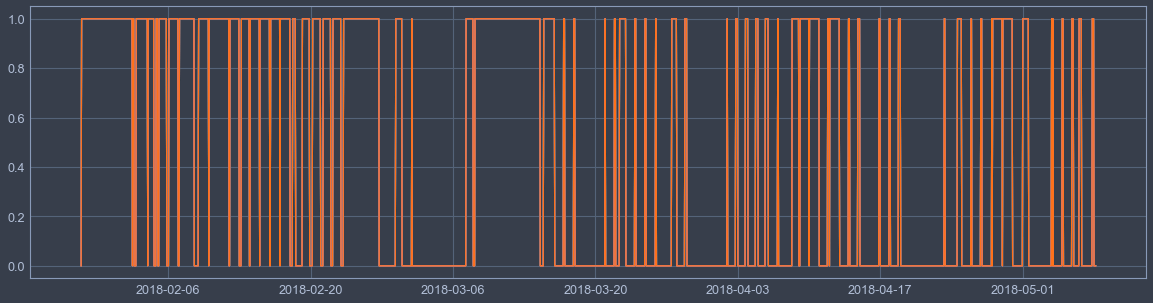

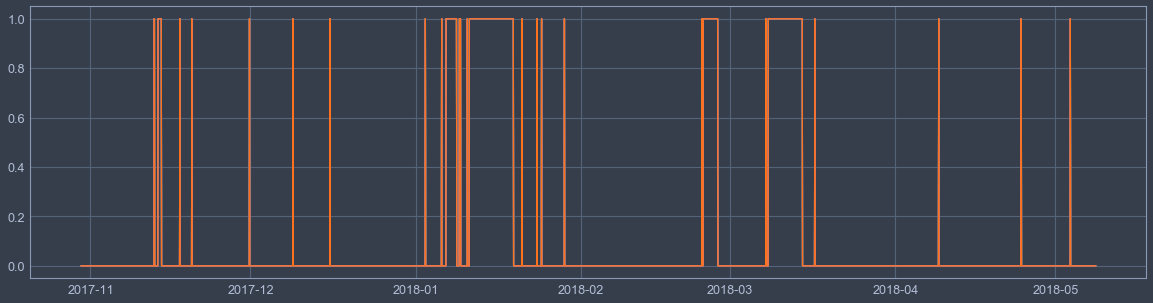

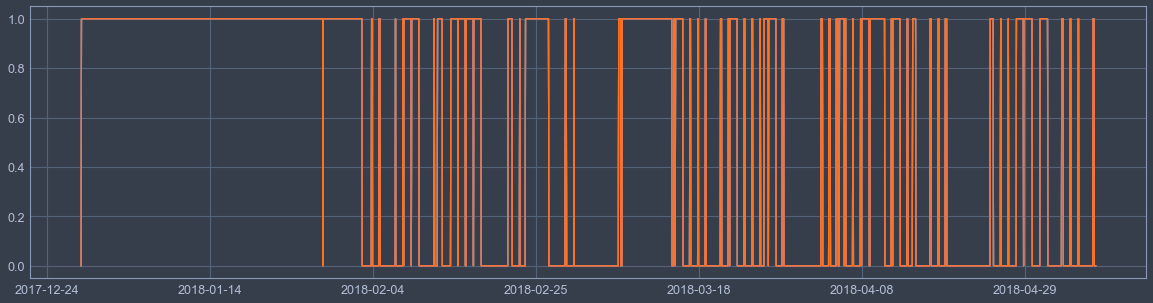

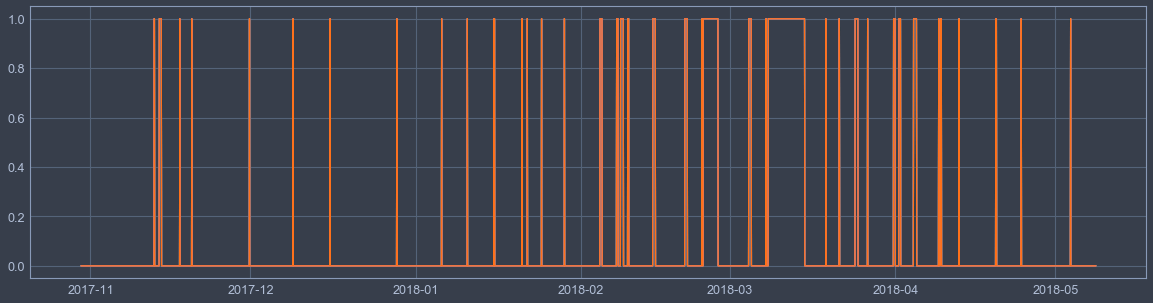

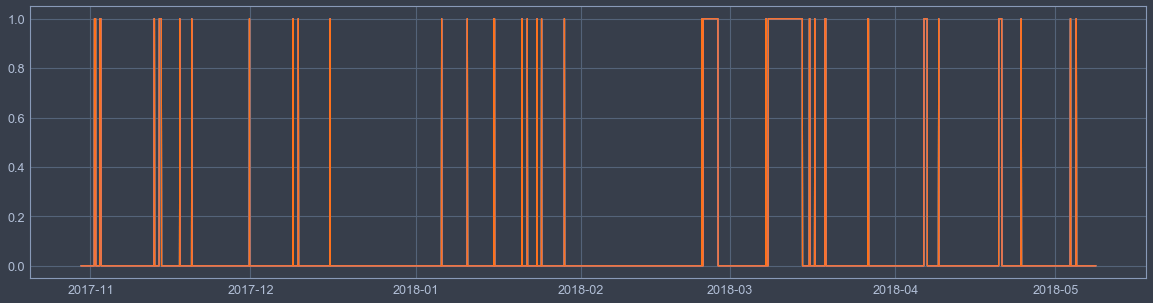

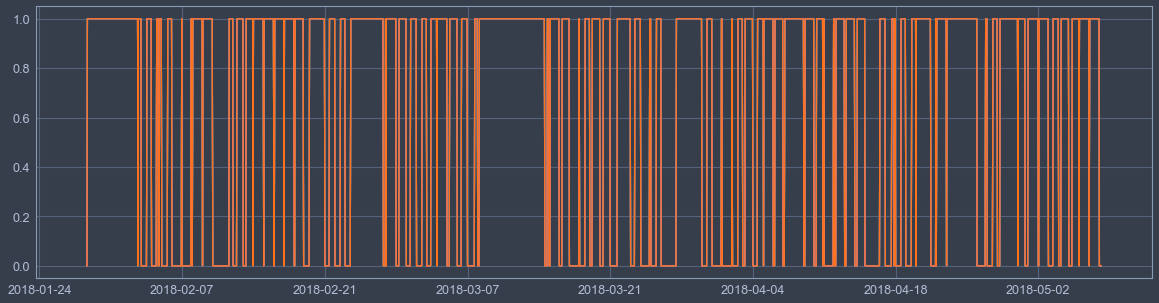

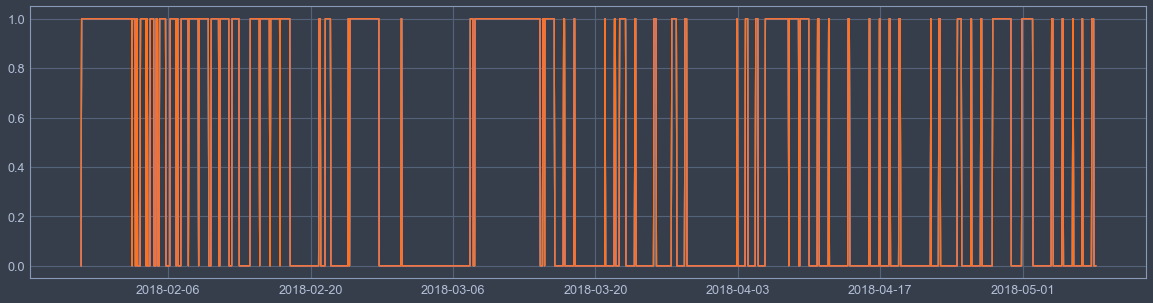

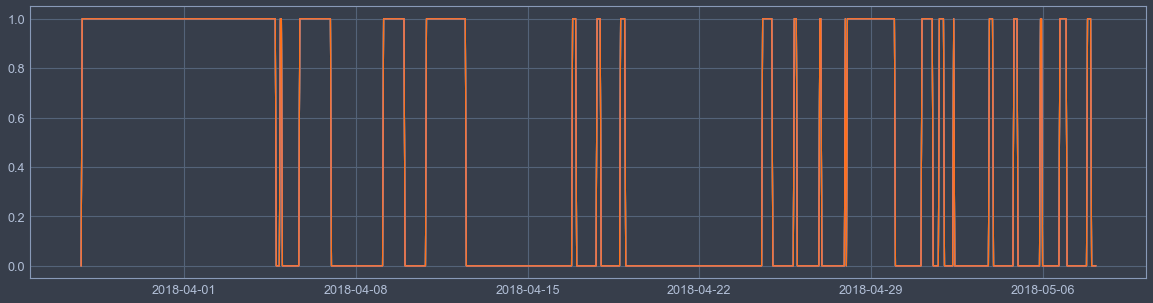

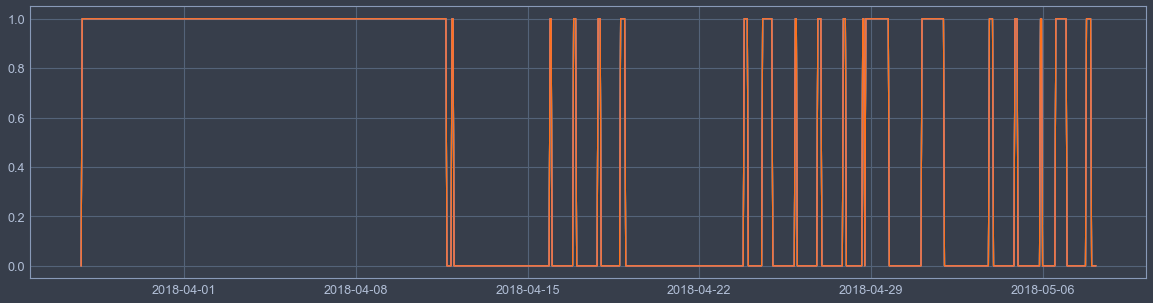

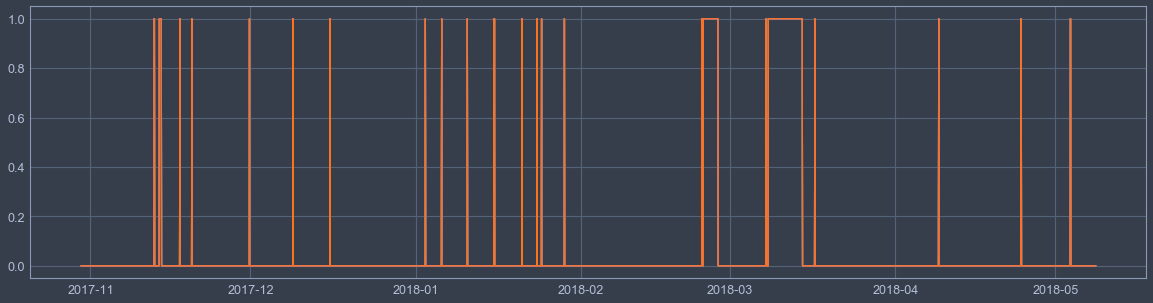

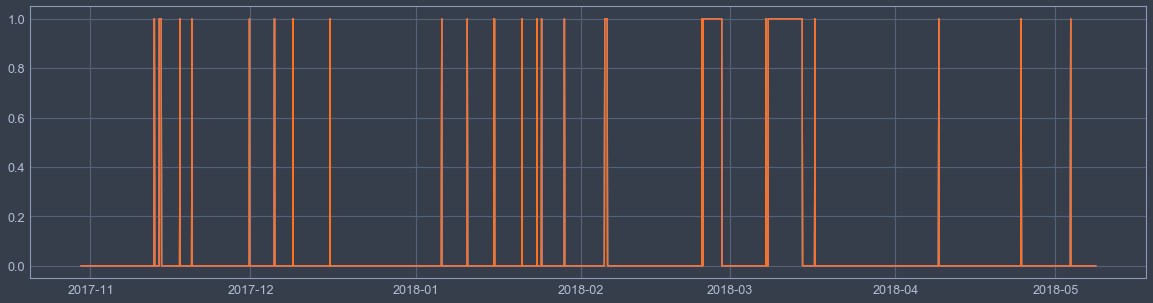

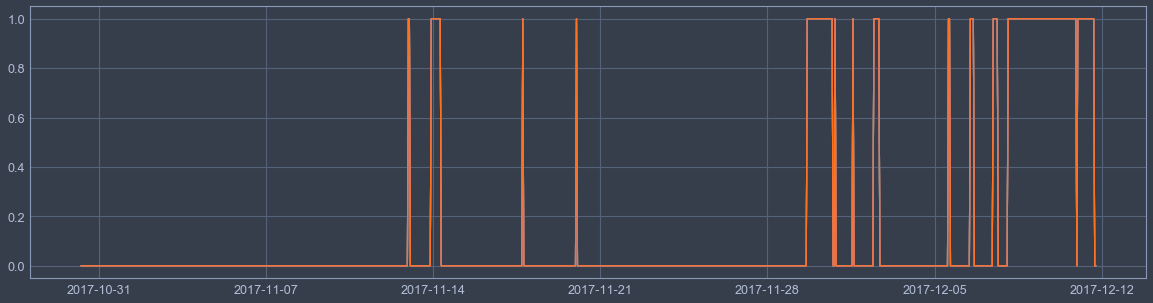

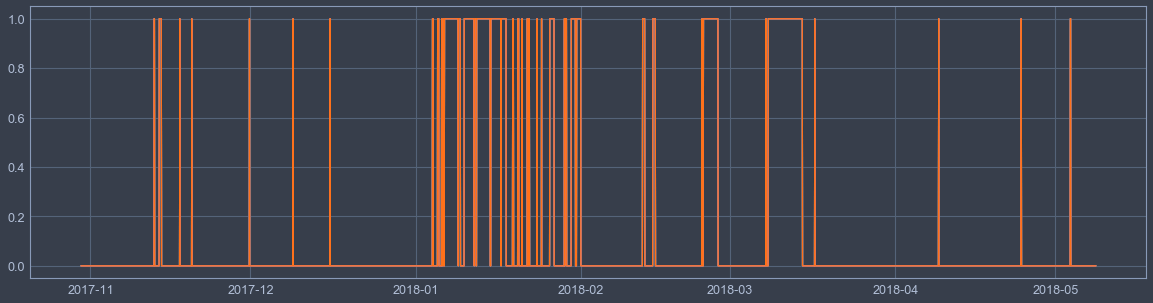

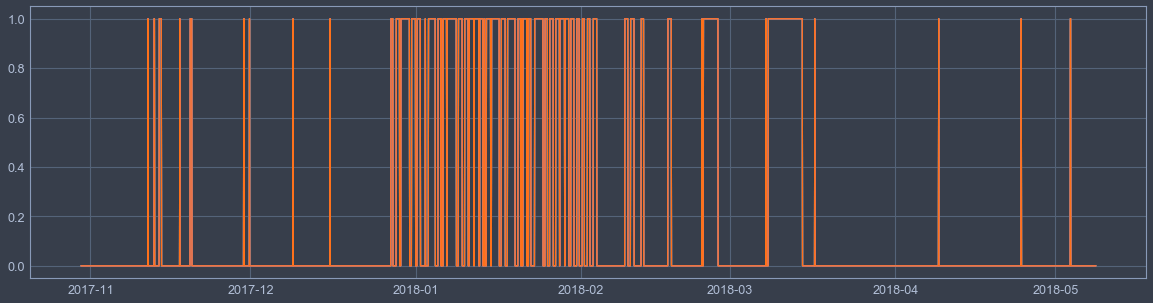

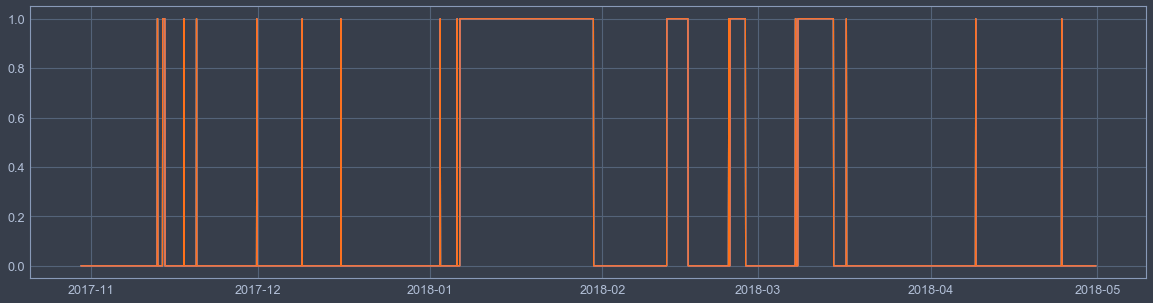

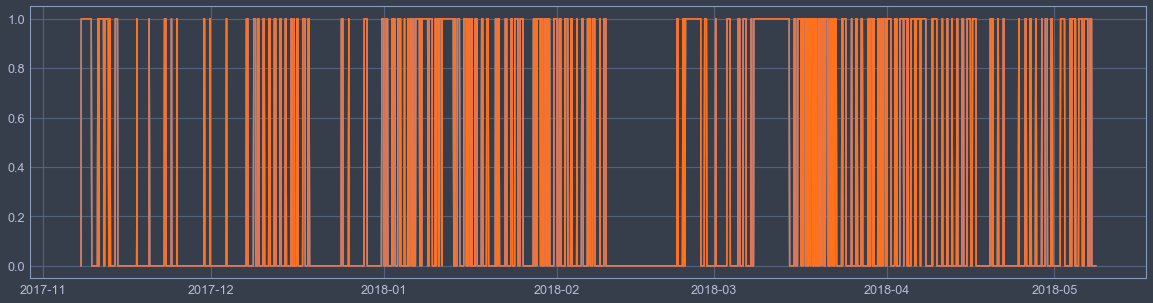

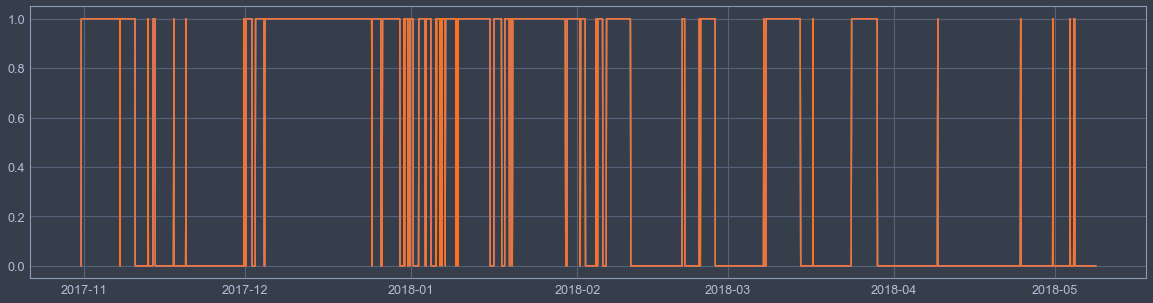

In [78]:
for station in stations:
    plt.figure(figsize=(20, 5))
    plt.plot(hourly_data.isnull().loc[station])
    plt.show()

In [72]:
hourly_data.isnull().groupby('solbox_id')['day'].mean()

solbox_id
190   0.46
30    0.11
309   0.53
32    0.09
34    0.07
344   0.68
345   0.40
366   0.40
369   0.47
37    0.06
40    0.06
43    0.14
47    0.14
48    0.20
68    0.21
71    0.32
97    0.47
Name: day, dtype: float64

### Analyze time patterns on different variables

In [ ]:
hourly_data['computed_load'] = hourly_data['fILoadDirect_avg'] + hourly_data['fIToBat_avg'] + hourly_data['fIToGrid_avg']
hourly_data['load_difference'] = hourly_data['computed_load'] - hourly_data['fILoadDirect_avg'] 
hourly_data['load_direct_difference'] = hourly_data['computed_load'] - hourly_data['fILoad_avg'] 


In [53]:
hourly_data.head()

day  fIExcess_avg  fILoadDirect_avg  \
datetime            solbox_id                                         
2017-10-30 06:00:00 30        30.00          8.41           4317.13   
                    32        30.00          8.41           3260.81   
                    34        30.00          8.41           1275.76   
                    37        30.00          8.41           3209.01   
                    40        30.00          8.70           3902.13   

                               fILoad_avg  fIPV_avg  fIToBat_avg  \
datetime            solbox_id                                      
2017-10-30 06:00:00 30           53931.76  31980.50     -1793.40   
                    32           53797.30  32335.28     -1246.40   
                    34           53144.43  31496.88     -1175.13   
                    37           53923.00  32870.33      -322.86   
                    40           61323.86  35953.17     -4106.18   

                               fIToGrid_avg  fTemperature_avg  hour  month  \
datetime            solbox_id                                                
2017-10-30 06:00:00 30               154.58             26.03  6.00  10.00   
                    32                96.86             24.43  6.00  10.00   
                    34              -159.90             24.48  6.00  10.00   
                    37              -417.40             25.74  6.00  10.00   
                    40              -251.54             32.84  6.00  10.00   

                               u8StateOfBattery    year  computed_load  \
datetime            solbox_id                                            
2017-10-30 06:00:00 30                     3.00 2017.00       30341.68   
                    32                     3.00 2017.00       31185.74   
                    34                     3.00 2017.00       30161.85   
                    37                     3.00 2017.00       32130.07   
                    40                     3.00 2017.00       31595.45   

                               load_difference  load_direct_difference  
datetime            solbox_id                                           
2017-10-30 06:00:00 30                26024.55               -23590.08  
                    32                27924.93               -22611.56  
                    34                28886.09               -22982.58  
                    37                28921.06               -21792.93  
                    40                27693.32               -29728.41

In [17]:
hourly_data[currents].head()

fILoadDirect_avg  fILoad_avg  fIPV_avg  \
solbox_id datetime                                                      
190       2018-01-28 11:00:00            763.10     2533.30   1142.58   
          2018-02-02 12:00:00            134.40     1946.26   1514.66   
          2018-02-02 16:00:00            135.25     1951.17   1190.97   
          2018-02-02 17:00:00            344.26     2166.99   1159.90   
          2018-02-02 18:00:00            583.20     2415.47   1155.39   

                               fIExcess_avg  fIToGrid_avg  fIToBat_avg  \
solbox_id datetime                                                       
190       2018-01-28 11:00:00          0.79          0.00         0.00   
          2018-02-02 12:00:00          0.29        -12.56       281.39   
          2018-02-02 16:00:00          0.38        -14.15       -45.62   
          2018-02-02 17:00:00          0.29        -63.34      -243.32   
          2018-02-02 18:00:00          0.29        -97.24      -462.41   

                               fTemperature_avg  computed_load  \
solbox_id datetime                                               
190       2018-01-28 11:00:00             23.75        1142.58   
          2018-02-02 12:00:00             22.28        2064.88   
          2018-02-02 16:00:00             24.26        1085.58   
          2018-02-02 17:00:00             23.87         609.92   
          2018-02-02 18:00:00             23.40         133.33   

                               load_difference  
solbox_id datetime                              
190       2018-01-28 11:00:00             0.00  
          2018-02-02 12:00:00           550.22  
          2018-02-02 16:00:00          -105.39  
          2018-02-02 17:00:00          -549.98  
          2018-02-02 18:00:00         -1022.06

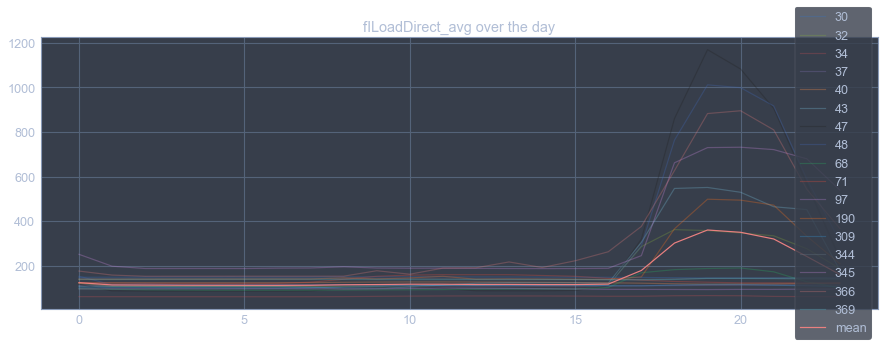

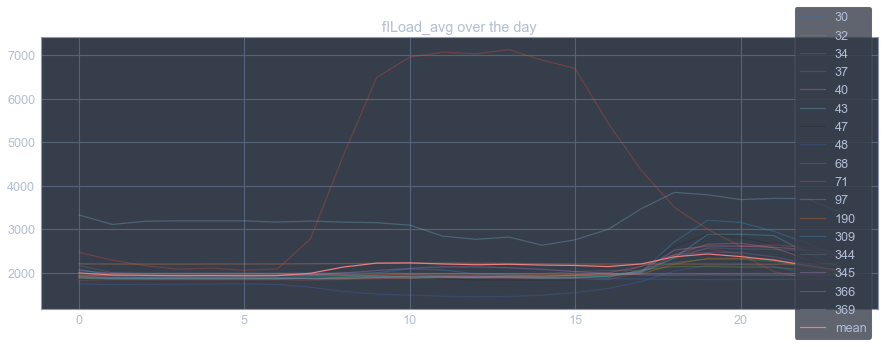

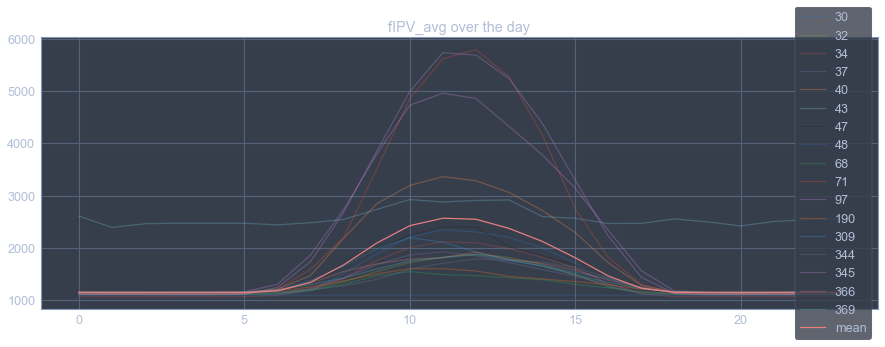

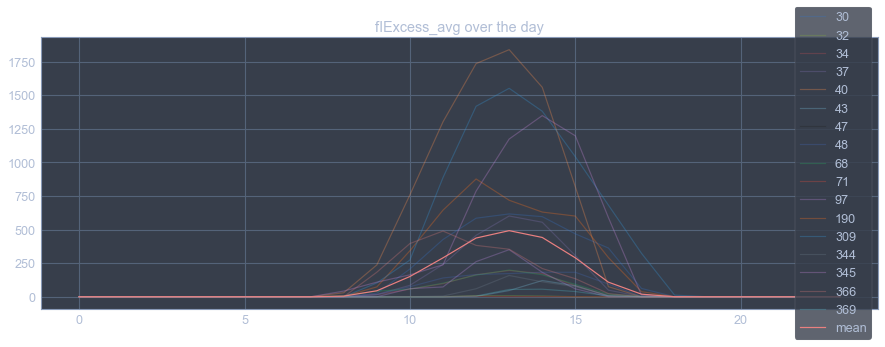

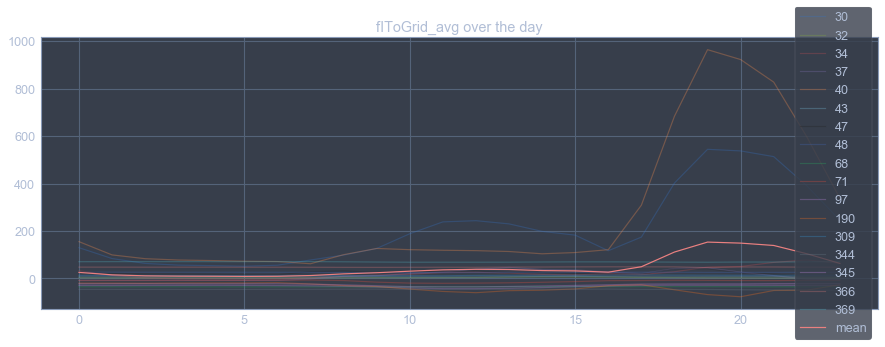

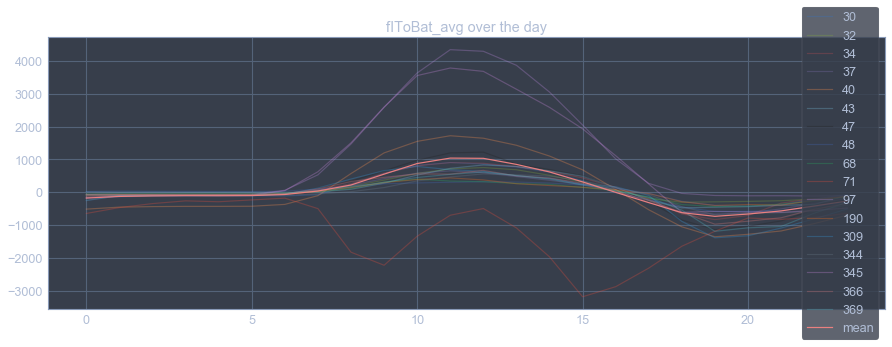

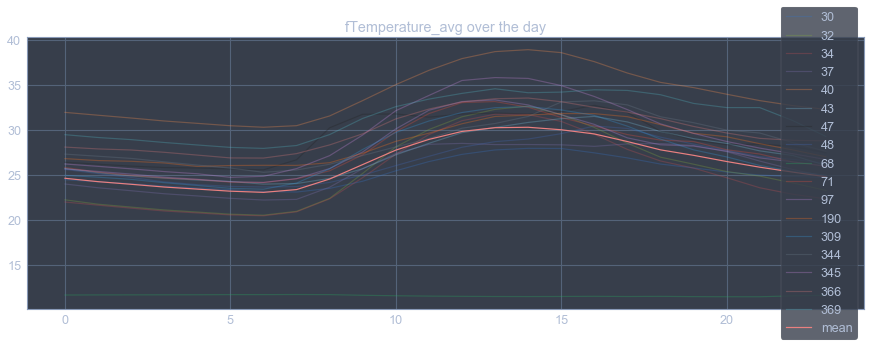

In [5]:
# Visualize currents over the day
for var in currents:
    plt.figure(figsize=(15, 5))
    for station in stations:
        plt.plot(data_hourly.loc[station].groupby('hour')[var].mean(), label=station, alpha=0.3)
        
    plt.plot(data_hourly.groupby('hour')[var].mean(), label='mean')
    plt.title('{} over the day'.format(var))
    plt.legend(loc='right')
    plt.show()

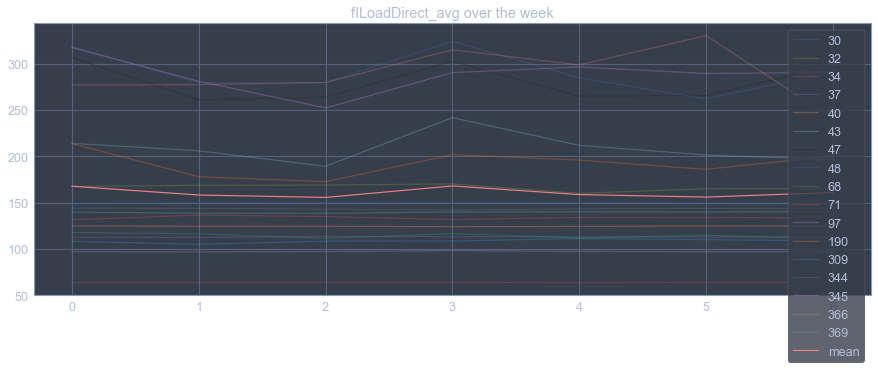

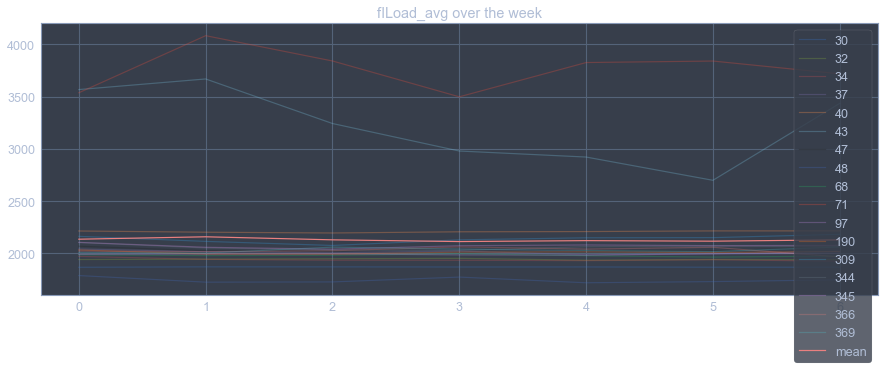

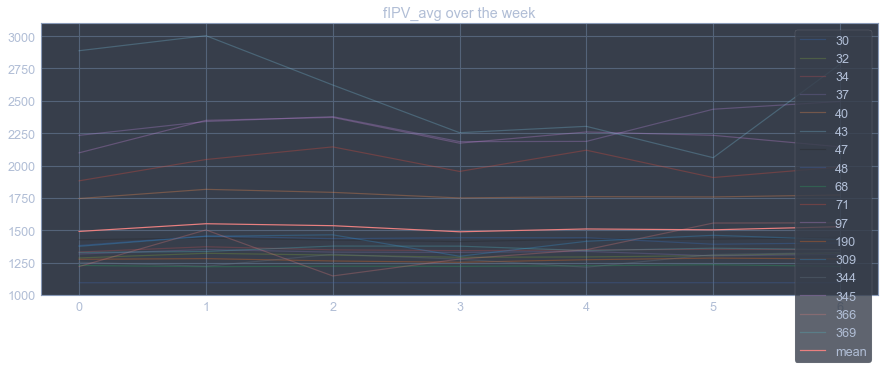

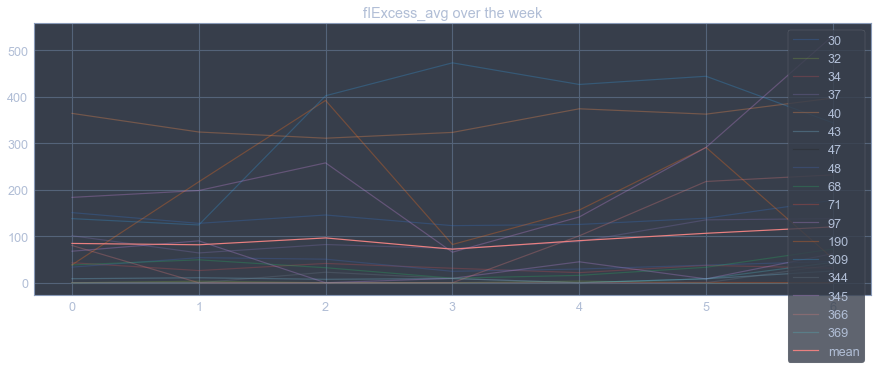

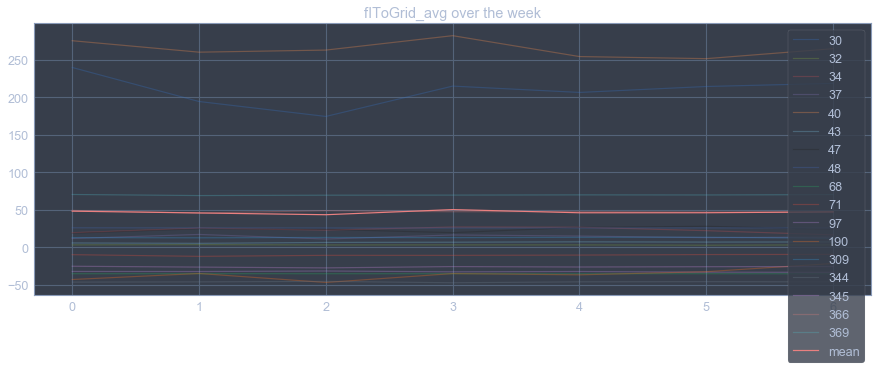

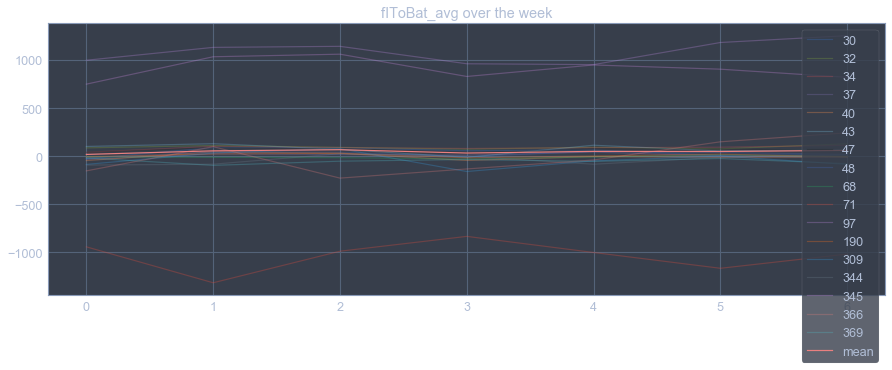

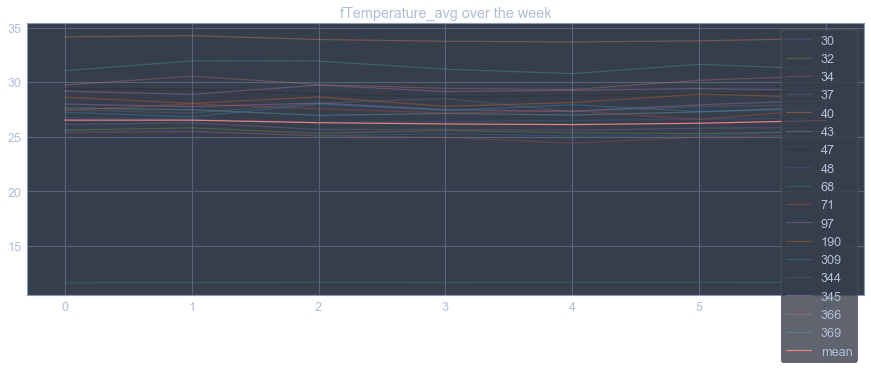

In [6]:
# Visualize voltages over the week
for var in currents:
    plt.figure(figsize=(15, 5))
    for station in stations:
        plt.plot(data_hourly.loc[station].groupby('weekday')[var].mean(), label=station, alpha=0.3)
        
    plt.plot(data_hourly.groupby('weekday')[var].mean(), label='mean')
    plt.title('{} over the week'.format(var))
    plt.legend()
    plt.show()

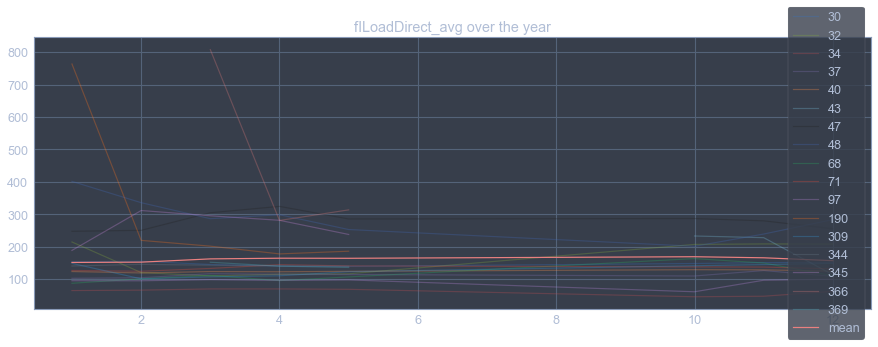

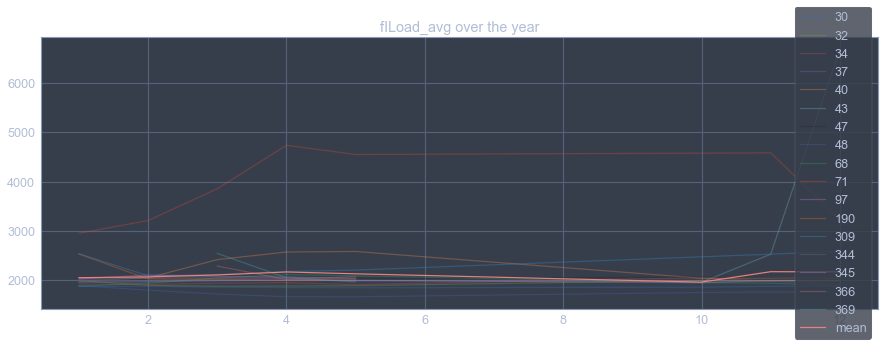

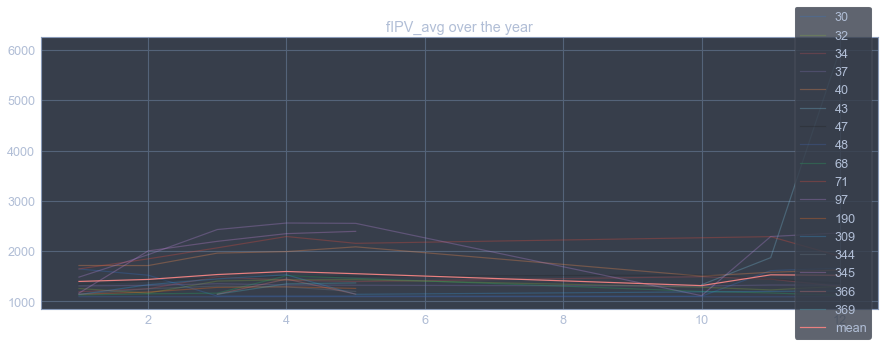

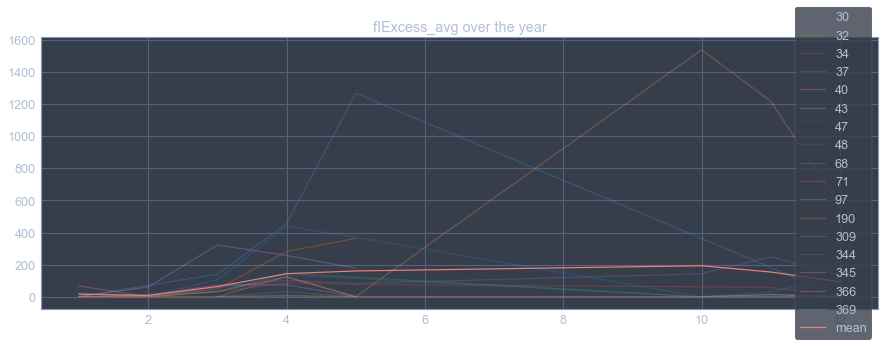

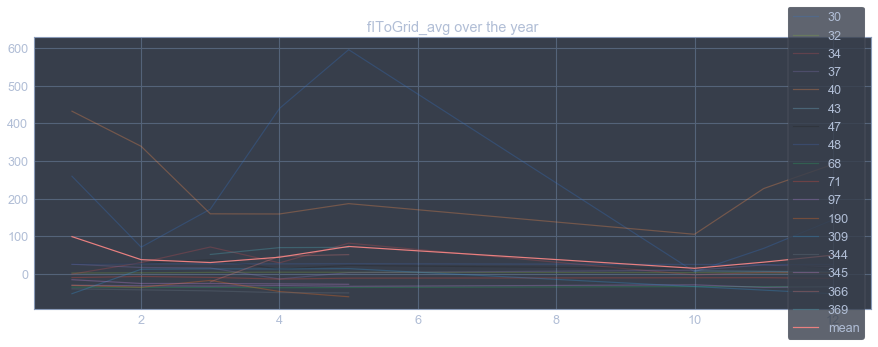

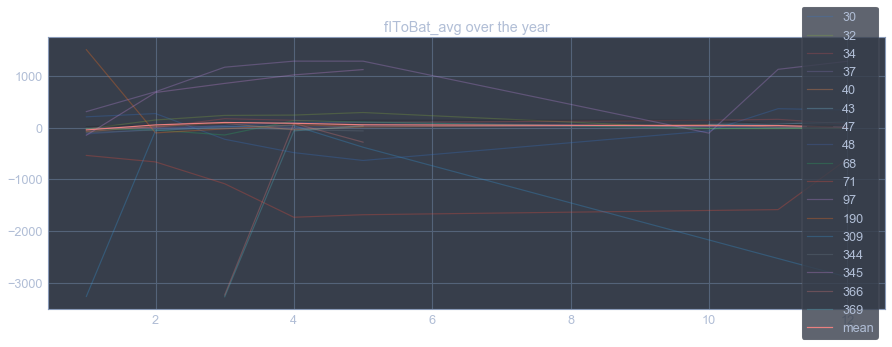

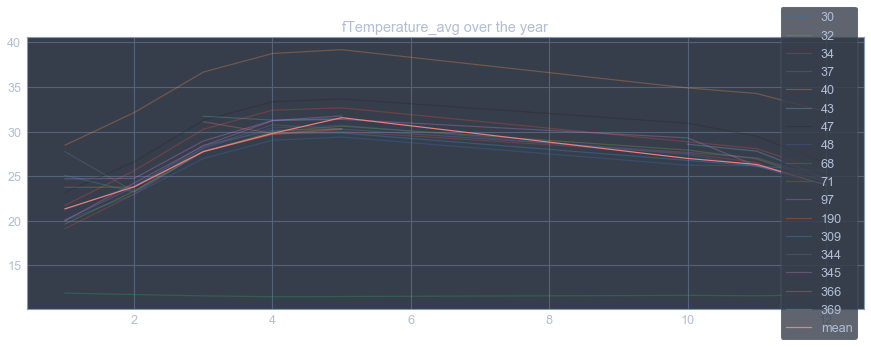

In [7]:
# Visualize voltages over the year
for var in currents:
    plt.figure(figsize=(15, 5))
    for station in stations:
        plt.plot(data_hourly.loc[station].groupby('month')[var].mean(), label=station, alpha=0.3)
        
    plt.plot(data_hourly.groupby('month')[var].mean(), label='mean')
    plt.title('{} over the year'.format(var))
    plt.legend(loc='right')
    plt.show()

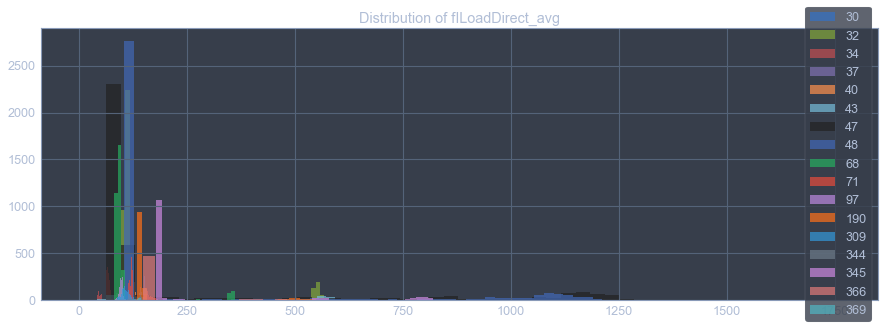

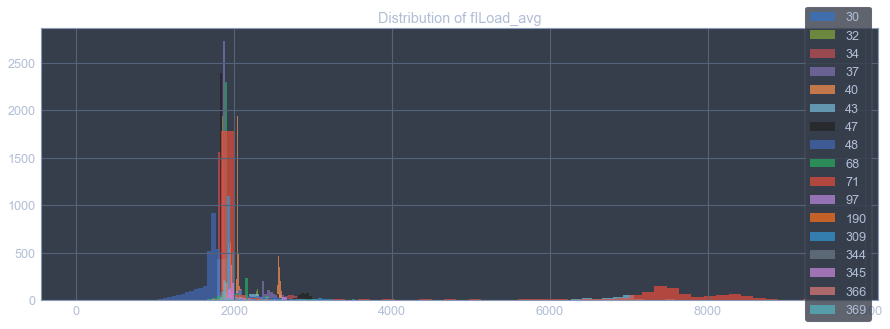

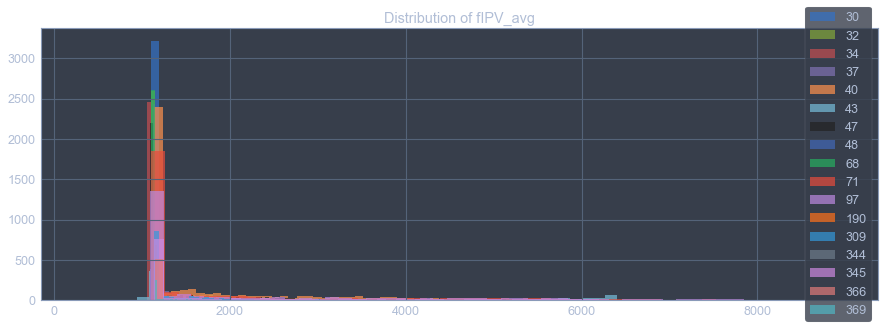

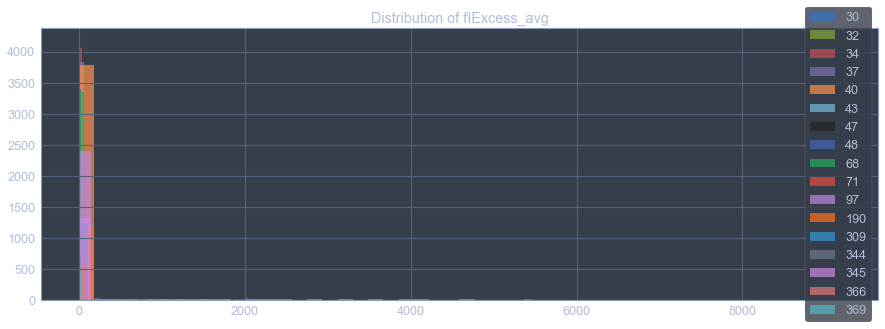

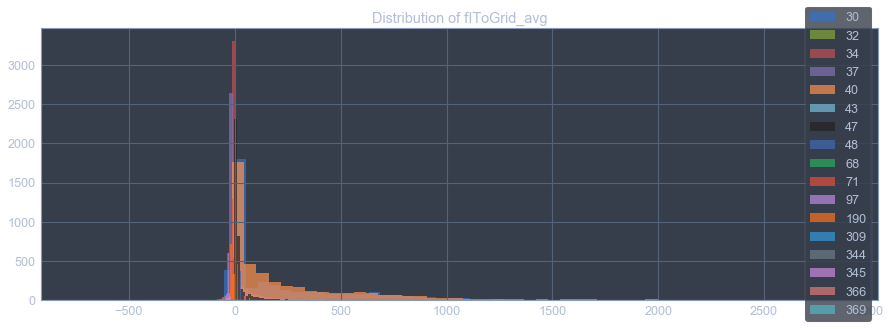

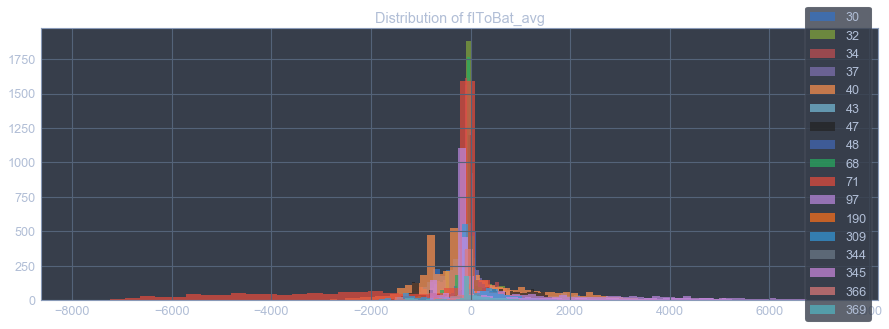

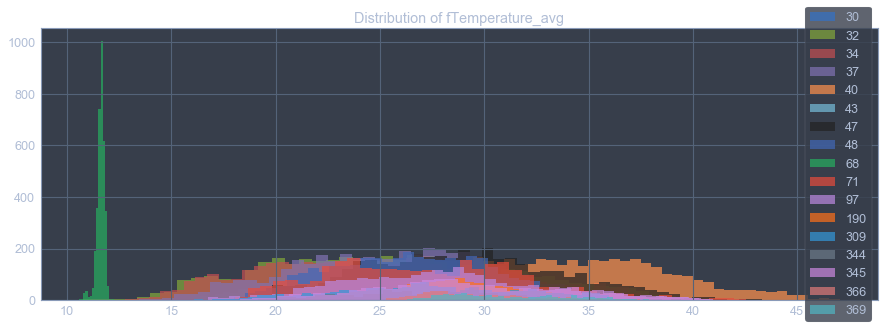

In [8]:
for var in currents:
    plt.figure(figsize=(15, 5))
    for station in stations:
        plt.hist(data_hourly.loc[station, var].dropna().values, bins=50, label=str(station), alpha=0.7)
        
    plt.title('Distribution of {}'.format(var))
    plt.legend(loc='right')
    plt.show()

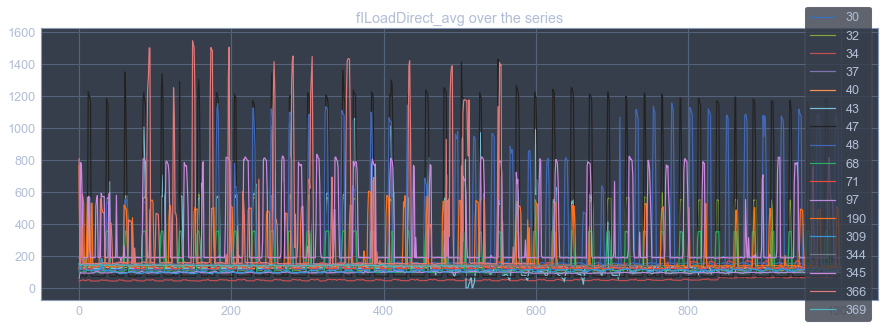

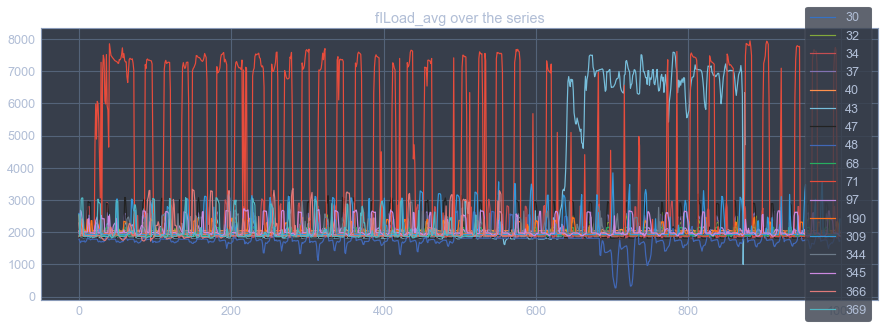

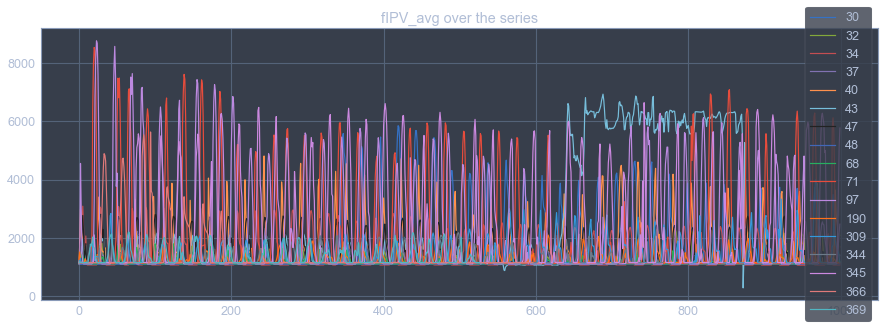

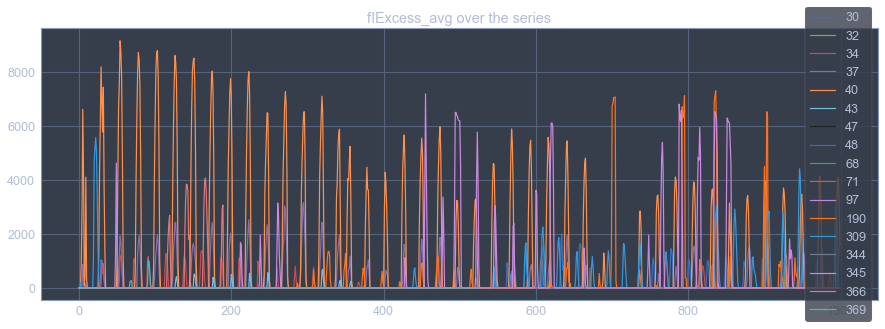

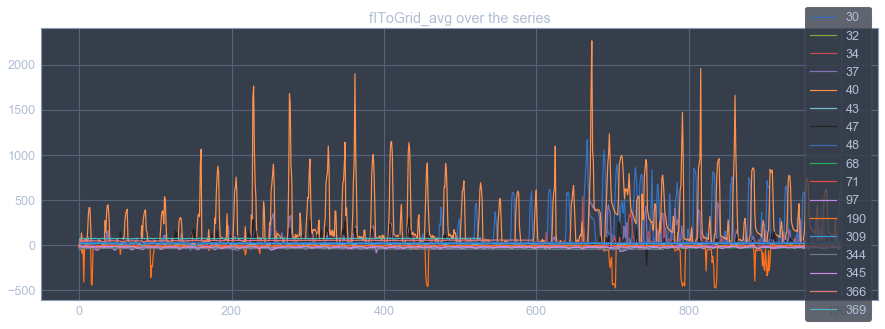

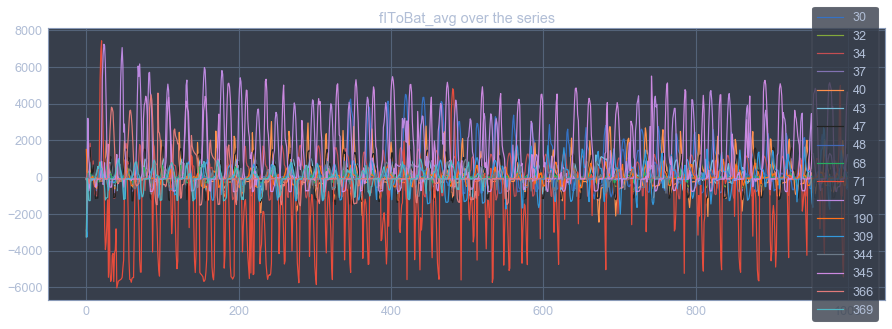

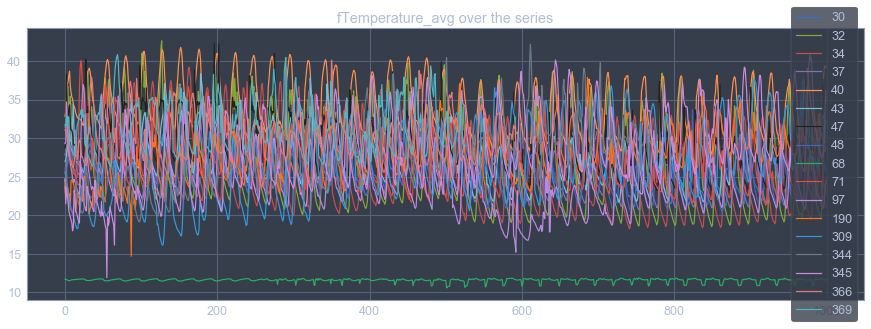

In [9]:
for var in currents:
    plt.figure(figsize=(15, 5))
    for station in stations:
        plt.plot(data_hourly.loc[station, var].iloc[:1000].values, label=station)
        
    plt.title('{} over the series'.format(var))
    plt.legend(loc='right')
    plt.show()

### Exploration ideas
1. - How much energy doesn't get used because of the battery being full and nobody buying energy?

In [63]:
data['fILoad_avg'].groupby('solbox_id').sum()

solbox_id
190    69811330.98
30    205640734.13
309    86372551.94
32    217659714.76
34    222398882.83
344    38941165.74
345    80080339.66
366    32747086.35
369    28503598.06
37    223928882.74
40    255828065.35
43     70517306.56
47    209942208.30
48    169176563.48
68    184663934.33
71    279984506.81
97    127742884.81
Name: fILoad_avg, dtype: float64

In [64]:
data['fIExcess_avg'].groupby('solbox_id').sum()

solbox_id
190    6142705.36
30    15993500.48
309   13666258.34
32      156635.19
34     4056492.67
344     201152.16
345    9363172.98
366    1633134.41
369     106171.30
37    10777028.89
40    41701122.50
43      247202.47
47       44646.31
48     4110832.81
68     3487235.98
71       30712.29
97     2759011.03
Name: fIExcess_avg, dtype: float64

In [66]:
#1. - How much energy doesn't get used because of the battery being full and nobody buying energy?
print(data['fIExcess_avg'].groupby('solbox_id').sum() / data['fILoad_avg'].groupby('solbox_id').sum())
print(data['fIExcess_avg'].groupby('solbox_id').sum().sum() / data['fILoad_avg'].groupby('solbox_id').sum().sum())

solbox_id
190   0.09
30    0.08
309   0.16
32    0.00
34    0.02
344   0.01
345   0.12
366   0.05
369   0.00
37    0.05
40    0.16
43    0.00
47    0.00
48    0.02
68    0.02
71    0.00
97    0.02
dtype: float64
0.04571875775270569


In [13]:
## Modelling